# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import stats
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


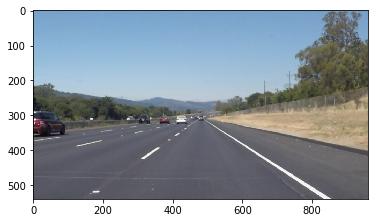

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [276]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    """
    Modification to helper function: returning mask instead of the masked image
    allows the use of the raw mask to find average color within the region
    """
    
    return mask
    
    # #returning the image only where mask pixels are nonzero
    # masked_image = cv2.bitwise_and(img, mask)
    # return masked_image


def draw_lines(img, lines, line_height, slope_limit, \
               color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    # first check that we have valid input lines
    if lines.size == 0:
        raise InputError('No lines in input to draw_lines')
    
    # draw raw Hough lines onto image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, 2)
            
    # plt.imsave("test_videos_output/last_frame_lines.jpg", img)
    
    # to generate average lines, we'll need to know slope, y-intercept,
    # and length of each line segment
    lines_mbl = np.array([[x1, x2, (y2-y1)/(x2-x1), y1-x1*(y2-y1)/(x2-x1), \
                           math.sqrt((x2-x1)**2+(y2-y1)**2)] \
                           for line in lines for x1,y1,x2,y2 in line])
    
    # Remove 2 kinds of unwanted lines:
    # 1) verticals (x1 == x2): unfortunately they throw off any averaging
    # 2) lines flatter than an expected lane line should be (slope limit)
    lines_mbl = np.array([l for l in lines_mbl \
                          if (l[0] != l[1] and \
                             (l[2] > slope_limit or l[2] < -slope_limit))])
    
    # split line segments into slope < 0 (left) and slope > 0 (right)
    onleft_lines = np.array([l for l in lines_mbl if l[2] < 0])
    onright_lines = np.array([l for l in lines_mbl if l[2] > 0])
    
    # check that we have lines remaining after separation
    if onleft_lines.size == 0:
        raise ValueError('No lines in onleft_lines')
    if onright_lines.size == 0:
        raise ValueError('No lines in onright_lines')
    
    # remove segments shorter than average, use only the longest
    # (assumed the most reliable) segments to build "average" line
    if onleft_lines.size > 1:
        avg_lg_left = np.mean(onleft_lines, axis=0)[4]
        onleft_lines = np.array([line for line in onleft_lines \
                                 if line[4] >= avg_lg_left])
        avg_left_line = np.average(onleft_lines, axis = 0)
    else:
        avg_left_line = onleft_lines
    
    if onright_lines.size > 1:
        avg_lg_right = np.mean(onright_lines, axis=0)[4]
        onright_lines = np.array([line for line in onright_lines \
                                  if line[4] >= avg_lg_right])
        avg_right_line = np.average(onright_lines, axis = 0)
    else:
        avg_right_line = onright_lines
    
    # generate points to draw the new average lines onto the frame
    left_y1 = img.shape[0]
    left_x1 = int((left_y1 - avg_left_line[3]) / avg_left_line[2])
    left_y2 = int(img.shape[0] * line_height)
    left_x2 = int((left_y2 - avg_left_line[3]) / avg_left_line[2])
    right_y1 = img.shape[0]
    right_x1 = int((right_y1 - avg_right_line[3]) / avg_right_line[2])
    right_y2 = int(img.shape[0] * line_height)
    right_x2 = int((right_y2 - avg_right_line[3]) / avg_right_line[2])
    
    # more scalable, original code snippet for =>2 line segments
    # 
    # avg_lines = np.array([[[left_x1, left_y1, left_x2, left_y2], \
    #                        [right_x1, right_y1, right_x2, right_y2]]])
    # 
    # for line in avg_lines:
    #     for x1,y1,x2,y2 in line:
    #         cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    # faster way to plot two lines IF we only have two
    cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)
    cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
    
    # plt.imsave("test_videos_output/last_frame_avgs.jpg", img)

def hough_lines(img, line_height, slope_limit, rho, theta, threshold, \
                min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), \
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, line_height, slope_limit)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [259]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [260]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

# Control Points: Directories, parameters, and other constants
# 
# Directories
INPUTDIR = "test_images/"
OUTPUTDIR = "test_images_output/"
#
# Parameters
REGION_UPPER_BOUND = 0.60   # Sizes region of interest to "apex" at the horizon
                            # Can be adjusted for camera aiming
REGION_APEX_WIDTH = 0.03    # Sizes "lane width" at apex to include in analysis
BLUR_KERNEL_SIZE = 5
CANNY_LOW_THRESHOLD = 50
CANNY_HIGH_THRESHOLD = 150
HOUGH_RHO = 2
HOUGH_THETA = np.pi/180
HOUGH_THRESHOLD = 15
HOUGH_MIN_LINE_LENGTH = 40
HOUGH_MAX_LINE_GAP = 30
LINE_SLOPE_THRESHOLD = 0.45 # Cutoff for how "flat" a line can be in the image
                            # and still be considered a possible lane line


# Get the list of images
files = os.listdir(INPUTDIR)

for filename in files:
    
    # Read in each image, report stats to confirm
    image = mpimg.imread(INPUTDIR + filename)
    print('Imported:', filename, type(image), 'with dimensions:', image.shape)
    
    xsize = image.shape[1]
    ysize = image.shape[0]
    
    # Assumption: if lane lines are always lighter and much narrower than 
    # the road, we can use a region mask to isolate the road pixels directly ahead
    # of the vehicle, calculate the "average color" of the road, and mask off
    # any features that aren't light enough to be lane lines. Combine with edge
    # finding and slope checking to confirm when lines are lane lines, not just 
    # lines on the road (for example, expansion joints on a bridge).
    
    # Set the region mask
    # Assumption: camera is leveled and road is straight enough that we can use the
    # center of the image as the "perspective point". The height and width of the
    # apex can be adjusted in #Parameters.
    left_bottom = [0, ysize]
    right_bottom = [xsize, ysize]
    apex_left = [xsize * (0.5 - REGION_APEX_WIDTH/2), ysize * REGION_UPPER_BOUND]
    apex_right = [xsize * (0.5 + REGION_APEX_WIDTH/2), ysize * REGION_UPPER_BOUND]
    vertices = np.array([[left_bottom, apex_left, apex_right, right_bottom]], \
                        dtype='int32')
    
    region = region_of_interest(image, vertices)  # returns polygonal region
    
    # Gaussian smooth + Canny edge finding
    gray_image = grayscale(image)
    blur_gray = cv2.GaussianBlur(gray_image,(BLUR_KERNEL_SIZE, BLUR_KERNEL_SIZE), 0)
    edges = canny(blur_gray, CANNY_LOW_THRESHOLD, CANNY_HIGH_THRESHOLD)
    
    masked_edges = cv2.bitwise_and(edges, region[:,:,0])

    # Draw Hough lines and process to extract lane lines
    lines = hough_lines(masked_edges, REGION_UPPER_BOUND, LINE_SLOPE_THRESHOLD, \
                        HOUGH_RHO, HOUGH_THETA, HOUGH_THRESHOLD, \
                        HOUGH_MIN_LINE_LENGTH, HOUGH_MAX_LINE_GAP)
    
    overlaid_image = weighted_img(lines, image)
    
    outputname = "Lines_" + filename
    plt.imsave(OUTPUTDIR + outputname, overlaid_image)
    print('Saved:   ', outputname, type(image), 'with dimensions:', image.shape)


Imported: solidWhiteCurve.jpg <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Saved:    Lines_solidWhiteCurve.jpg <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Imported: solidWhiteRight.jpg <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Saved:    Lines_solidWhiteRight.jpg <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Imported: solidYellowCurve.jpg <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Saved:    Lines_solidYellowCurve.jpg <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Imported: solidYellowCurve2.jpg <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Saved:    Lines_solidYellowCurve2.jpg <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Imported: solidYellowLeft.jpg <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Saved:    Lines_solidYellowLeft.jpg <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Imported: whiteCarLaneSwitch.jpg <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Saved:    Lines_whiteCarLa

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [261]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [274]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    
    # Parameters
    REGION_HEIGHT_FACTOR = 0.60 # Sizes region of interest to "apex" at the horizon
                                # Can be adjusted for camera aiming
    REGION_APEX_WIDTH = 0.03    # Sizes "lane width" at apex to include in analysis
    BLUR_KERNEL_SIZE = 5
    CANNY_LOW_THRESHOLD = 75
    CANNY_HIGH_THRESHOLD = 150
    HOUGH_RHO = 2
    HOUGH_THETA = np.pi/180
    HOUGH_THRESHOLD = 10
    HOUGH_MIN_LINE_LENGTH = 25
    HOUGH_MAX_LINE_GAP = 20
    LINE_SLOPE_THRESHOLD = 0.45 # Cutoff for how "flat" a line can be in the image
                                # and still be considered a possible lane line
    
    
    # Assumption: if lane lines are always lighter and much narrower than 
    # the road, we can use a region mask to isolate the road pixels directly ahead
    # of the vehicle, calculate the "average color" of the road, and mask off
    # any features that aren't light enough to be lane lines. Combine with edge
    # finding and slope checking to confirm when lines are lane lines, not just 
    # lines on the road (for example, expansion joints on a bridge).
    
    # Set the region mask
    # Assumption: camera is leveled and road is straight enough that we can use the
    # center of the image as the "perspective point". The height and width of the
    # apex can be adjusted in #Parameters.
    xsize = image.shape[1]
    ysize = image.shape[0]
    
    left_bottom = [0, ysize]
    right_bottom = [xsize, ysize]
    apex_left = [xsize * (0.5 - REGION_APEX_WIDTH/2), ysize * REGION_UPPER_BOUND]
    apex_right = [xsize * (0.5 + REGION_APEX_WIDTH/2), ysize * REGION_UPPER_BOUND]
    vertices = np.array([[left_bottom, apex_left, apex_right, right_bottom]], \
                        dtype='int32')
    
    region = region_of_interest(image, vertices)  # returns polygonal region
    
    # Gaussian smooth + Canny edge finding
    gray_image = grayscale(image)
    
    # plt.imsave("test_videos_output/last_frame_gray.jpg", gray_image, cmap='Greys_r')
    
    blur_gray = cv2.GaussianBlur(gray_image,(BLUR_KERNEL_SIZE, BLUR_KERNEL_SIZE), 0)
    edges = canny(blur_gray, CANNY_LOW_THRESHOLD, CANNY_HIGH_THRESHOLD)
    
    # plt.imsave("test_videos_output/last_frame_edges.jpg", edges, cmap='Greys_r')
    
    masked_edges = cv2.bitwise_and(edges, region[:,:,0])
    
    # plt.imsave("test_videos_output/last_frame_medges.jpg", masked_edges, cmap='Greys_r')

    # Draw Hough lines and process to extract lane lines
    lines = hough_lines(masked_edges, REGION_UPPER_BOUND, LINE_SLOPE_THRESHOLD, \
                        HOUGH_RHO, HOUGH_THETA, HOUGH_THRESHOLD, \
                        HOUGH_MIN_LINE_LENGTH, HOUGH_MAX_LINE_GAP)
    
    return weighted_img(lines, image)

Let's try the one with the solid white lane on the right first ...

In [275]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4

























  0%|          | 0/222 [00:00<?, ?it/s]






















  0%|          | 1/222 [00:00<00:49,  4.50it/s]






















  1%|          | 2/222 [00:00<00:49,  4.48it/s]






















  1%|▏         | 3/222 [00:00<00:50,  4.35it/s]






















  2%|▏         | 4/222 [00:00<00:50,  4.29it/s]






















  2%|▏         | 5/222 [00:01<00:53,  4.05it/s]






















  3%|▎         | 6/222 [00:01<00:51,  4.18it/s]






















  3%|▎         | 7/222 [00:01<00:50,  4.23it/s]






















  4%|▎         | 8/222 [00:01<00:49,  4.31it/s]






















  4%|▍         | 9/222 [00:02<00:50,  4.23it/s]






















  5%|▍         | 10/222 [00:02<00:50,  4.23it/s]






















  5%|▍         | 11/222 [00:02<00:50,  4.17it/s]






















  5%|▌         | 12/222 [00:02<00:48,  4.31it/s]






















  6%|▌         | 13/222 [00:03<00:50,  4.11it/s]






















 

 26%|██▌       | 58/222 [00:13<00:38,  4.27it/s]






















 27%|██▋       | 59/222 [00:13<00:37,  4.36it/s]






















 27%|██▋       | 60/222 [00:13<00:39,  4.10it/s]






















 27%|██▋       | 61/222 [00:14<00:38,  4.21it/s]






















 28%|██▊       | 62/222 [00:14<00:37,  4.24it/s]






















 28%|██▊       | 63/222 [00:14<00:36,  4.40it/s]






















 29%|██▉       | 64/222 [00:14<00:35,  4.44it/s]






















 29%|██▉       | 65/222 [00:15<00:34,  4.52it/s]






















 30%|██▉       | 66/222 [00:15<00:33,  4.65it/s]






















 30%|███       | 67/222 [00:15<00:34,  4.55it/s]






















 31%|███       | 68/222 [00:15<00:34,  4.49it/s]






















 31%|███       | 69/222 [00:15<00:33,  4.53it/s]






















 32%|███▏      | 70/222 [00:16<00:33,  4.55it/s]






















 32%|███▏      | 71/222 [00:16<00:32,  4.59it/s]






















 32%|█

 52%|█████▏    | 116/222 [00:26<00:24,  4.39it/s]






















 53%|█████▎    | 117/222 [00:26<00:24,  4.37it/s]






















 53%|█████▎    | 118/222 [00:26<00:23,  4.48it/s]






















 54%|█████▎    | 119/222 [00:27<00:23,  4.46it/s]






















 54%|█████▍    | 120/222 [00:27<00:22,  4.53it/s]






















 55%|█████▍    | 121/222 [00:27<00:22,  4.44it/s]






















 55%|█████▍    | 122/222 [00:27<00:21,  4.55it/s]






















 55%|█████▌    | 123/222 [00:28<00:22,  4.49it/s]






















 56%|█████▌    | 124/222 [00:28<00:21,  4.47it/s]






















 56%|█████▋    | 125/222 [00:28<00:21,  4.49it/s]






















 57%|█████▋    | 126/222 [00:28<00:22,  4.27it/s]






















 57%|█████▋    | 127/222 [00:28<00:21,  4.44it/s]






















 58%|█████▊    | 128/222 [00:29<00:22,  4.26it/s]






















 58%|█████▊    | 129/222 [00:29<00:21,  4.41it/s]
















 78%|███████▊  | 174/222 [00:40<00:10,  4.41it/s]






















 79%|███████▉  | 175/222 [00:40<00:10,  4.46it/s]






















 79%|███████▉  | 176/222 [00:40<00:10,  4.48it/s]






















 80%|███████▉  | 177/222 [00:40<00:10,  4.50it/s]






















 80%|████████  | 178/222 [00:41<00:09,  4.54it/s]






















 81%|████████  | 179/222 [00:41<00:09,  4.64it/s]






















 81%|████████  | 180/222 [00:41<00:09,  4.40it/s]






















 82%|████████▏ | 181/222 [00:41<00:09,  4.43it/s]






















 82%|████████▏ | 182/222 [00:41<00:09,  4.40it/s]






















 82%|████████▏ | 183/222 [00:42<00:08,  4.48it/s]






















 83%|████████▎ | 184/222 [00:42<00:08,  4.45it/s]






















 83%|████████▎ | 185/222 [00:42<00:08,  4.53it/s]






















 84%|████████▍ | 186/222 [00:42<00:07,  4.55it/s]






















 84%|████████▍ | 187/222 [00:43<00:07,  4.55it/s]
















[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 52.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [121]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [278]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
## clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,1.7)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


























  0%|          | 0/682 [00:00<?, ?it/s]























  0%|          | 1/682 [00:00<02:44,  4.15it/s]























  0%|          | 2/682 [00:00<02:37,  4.32it/s]























  0%|          | 3/682 [00:00<02:33,  4.41it/s]























  1%|          | 4/682 [00:00<02:33,  4.43it/s]























  1%|          | 5/682 [00:01<02:30,  4.49it/s]























  1%|          | 6/682 [00:01<02:28,  4.54it/s]























  1%|          | 7/682 [00:01<02:35,  4.35it/s]























  1%|          | 8/682 [00:01<02:29,  4.49it/s]























  1%|▏         | 9/682 [00:01<02:26,  4.60it/s]























  1%|▏         | 10/682 [00:02<02:25,  4.62it/s]























  2%|▏         | 11/682 [00:02<02:21,  4.76it/s]























  2%|▏         | 12/682 [00:02<02:20,  4.77it/s]























  2%|▏         | 13/682 [00:02<02:19,  4.78it/s]











  8%|▊         | 57/682 [00:12<02:26,  4.26it/s]























  9%|▊         | 58/682 [00:12<02:22,  4.39it/s]























  9%|▊         | 59/682 [00:13<02:19,  4.46it/s]























  9%|▉         | 60/682 [00:13<02:18,  4.51it/s]























  9%|▉         | 61/682 [00:13<02:16,  4.54it/s]























  9%|▉         | 62/682 [00:13<02:19,  4.44it/s]























  9%|▉         | 63/682 [00:13<02:16,  4.54it/s]























  9%|▉         | 64/682 [00:14<02:19,  4.43it/s]























 10%|▉         | 65/682 [00:14<02:15,  4.56it/s]























 10%|▉         | 66/682 [00:14<02:13,  4.60it/s]























 10%|▉         | 67/682 [00:14<02:10,  4.70it/s]























 10%|▉         | 68/682 [00:15<02:12,  4.64it/s]























 10%|█         | 69/682 [00:15<02:18,  4.41it/s]























 10%|█         | 70/682 [00:15<02:22,  4.31it/s]

















 17%|█▋        | 113/682 [00:25<02:22,  3.99it/s]























 17%|█▋        | 114/682 [00:26<02:29,  3.80it/s]























 17%|█▋        | 115/682 [00:26<02:28,  3.82it/s]























 17%|█▋        | 116/682 [00:26<02:24,  3.91it/s]























 17%|█▋        | 117/682 [00:26<02:18,  4.07it/s]























 17%|█▋        | 118/682 [00:27<02:18,  4.07it/s]























 17%|█▋        | 119/682 [00:27<02:14,  4.19it/s]























 18%|█▊        | 120/682 [00:27<02:13,  4.20it/s]























 18%|█▊        | 121/682 [00:27<02:15,  4.14it/s]























 18%|█▊        | 122/682 [00:27<02:13,  4.21it/s]























 18%|█▊        | 123/682 [00:28<02:09,  4.31it/s]























 18%|█▊        | 124/682 [00:28<02:08,  4.33it/s]























 18%|█▊        | 125/682 [00:28<02:06,  4.40it/s]























 18%|█▊        | 126/682 [00:28<02:04,  4.45it/s]



 25%|██▍       | 169/682 [00:39<02:08,  3.99it/s]























 25%|██▍       | 170/682 [00:39<02:10,  3.93it/s]























 25%|██▌       | 171/682 [00:39<02:12,  3.87it/s]























 25%|██▌       | 172/682 [00:39<02:05,  4.05it/s]























 25%|██▌       | 173/682 [00:40<01:59,  4.24it/s]























 26%|██▌       | 174/682 [00:40<02:00,  4.21it/s]























 26%|██▌       | 175/682 [00:40<01:59,  4.24it/s]























 26%|██▌       | 176/682 [00:40<01:58,  4.28it/s]























 26%|██▌       | 177/682 [00:40<01:56,  4.35it/s]























 26%|██▌       | 178/682 [00:41<01:55,  4.36it/s]























 26%|██▌       | 179/682 [00:41<01:55,  4.37it/s]























 26%|██▋       | 180/682 [00:41<01:58,  4.23it/s]























 27%|██▋       | 181/682 [00:41<01:56,  4.31it/s]























 27%|██▋       | 182/682 [00:42<01:54,  4.37it/s]



 33%|███▎      | 225/682 [00:52<01:45,  4.32it/s]























 33%|███▎      | 226/682 [00:52<01:46,  4.28it/s]























 33%|███▎      | 227/682 [00:52<01:44,  4.34it/s]























 33%|███▎      | 228/682 [00:52<01:44,  4.36it/s]























 34%|███▎      | 229/682 [00:53<01:42,  4.44it/s]























 34%|███▎      | 230/682 [00:53<01:41,  4.44it/s]























 34%|███▍      | 231/682 [00:53<01:40,  4.49it/s]























 34%|███▍      | 232/682 [00:53<01:44,  4.29it/s]























 34%|███▍      | 233/682 [00:54<01:44,  4.28it/s]























 34%|███▍      | 234/682 [00:54<01:42,  4.39it/s]























 34%|███▍      | 235/682 [00:54<01:39,  4.48it/s]























 35%|███▍      | 236/682 [00:54<01:37,  4.58it/s]























 35%|███▍      | 237/682 [00:54<01:41,  4.39it/s]























 35%|███▍      | 238/682 [00:55<01:39,  4.47it/s]



 41%|████      | 281/682 [01:05<01:30,  4.44it/s]























 41%|████▏     | 282/682 [01:05<01:30,  4.40it/s]























 41%|████▏     | 283/682 [01:05<01:30,  4.39it/s]























 42%|████▏     | 284/682 [01:06<01:30,  4.39it/s]























 42%|████▏     | 285/682 [01:06<01:28,  4.50it/s]























 42%|████▏     | 286/682 [01:06<01:27,  4.54it/s]























 42%|████▏     | 287/682 [01:06<01:27,  4.52it/s]























 42%|████▏     | 288/682 [01:06<01:25,  4.61it/s]























 42%|████▏     | 289/682 [01:07<01:26,  4.56it/s]























 43%|████▎     | 290/682 [01:07<01:25,  4.57it/s]























 43%|████▎     | 291/682 [01:07<01:27,  4.45it/s]























 43%|████▎     | 292/682 [01:07<01:27,  4.45it/s]























 43%|████▎     | 293/682 [01:08<01:29,  4.35it/s]























 43%|████▎     | 294/682 [01:08<01:26,  4.51it/s]



 49%|████▉     | 337/682 [01:17<01:15,  4.57it/s]























 50%|████▉     | 338/682 [01:18<01:21,  4.20it/s]























 50%|████▉     | 339/682 [01:18<01:21,  4.20it/s]























 50%|████▉     | 340/682 [01:18<01:19,  4.31it/s]























 50%|█████     | 341/682 [01:18<01:21,  4.17it/s]























 50%|█████     | 342/682 [01:18<01:17,  4.36it/s]























 50%|█████     | 343/682 [01:19<01:20,  4.22it/s]























 50%|█████     | 344/682 [01:19<01:21,  4.16it/s]























 51%|█████     | 345/682 [01:19<01:22,  4.09it/s]























 51%|█████     | 346/682 [01:19<01:23,  4.03it/s]























 51%|█████     | 347/682 [01:20<01:23,  4.00it/s]























 51%|█████     | 348/682 [01:20<01:20,  4.17it/s]























 51%|█████     | 349/682 [01:20<01:17,  4.28it/s]























 51%|█████▏    | 350/682 [01:20<01:15,  4.39it/s]



 58%|█████▊    | 393/682 [01:30<01:05,  4.39it/s]























 58%|█████▊    | 394/682 [01:30<01:04,  4.50it/s]























 58%|█████▊    | 395/682 [01:30<01:04,  4.47it/s]























 58%|█████▊    | 396/682 [01:31<01:02,  4.57it/s]























 58%|█████▊    | 397/682 [01:31<01:02,  4.55it/s]























 58%|█████▊    | 398/682 [01:31<01:01,  4.62it/s]























 59%|█████▊    | 399/682 [01:31<01:01,  4.62it/s]























 59%|█████▊    | 400/682 [01:32<01:02,  4.48it/s]























 59%|█████▉    | 401/682 [01:32<01:02,  4.52it/s]























 59%|█████▉    | 402/682 [01:32<01:01,  4.53it/s]























 59%|█████▉    | 403/682 [01:32<01:00,  4.60it/s]























 59%|█████▉    | 404/682 [01:32<01:00,  4.57it/s]























 59%|█████▉    | 405/682 [01:33<01:00,  4.59it/s]























 60%|█████▉    | 406/682 [01:33<01:01,  4.50it/s]



 66%|██████▌   | 449/682 [01:43<00:51,  4.49it/s]























 66%|██████▌   | 450/682 [01:43<00:52,  4.46it/s]























 66%|██████▌   | 451/682 [01:43<00:52,  4.36it/s]























 66%|██████▋   | 452/682 [01:43<00:51,  4.51it/s]























 66%|██████▋   | 453/682 [01:43<00:51,  4.43it/s]























 67%|██████▋   | 454/682 [01:44<00:50,  4.50it/s]























 67%|██████▋   | 455/682 [01:44<00:49,  4.62it/s]























 67%|██████▋   | 456/682 [01:44<00:48,  4.64it/s]























 67%|██████▋   | 457/682 [01:44<00:48,  4.64it/s]























 67%|██████▋   | 458/682 [01:45<00:48,  4.60it/s]























 67%|██████▋   | 459/682 [01:45<00:47,  4.65it/s]























 67%|██████▋   | 460/682 [01:45<00:47,  4.72it/s]























 68%|██████▊   | 461/682 [01:45<00:49,  4.47it/s]























 68%|██████▊   | 462/682 [01:45<00:49,  4.48it/s]



 74%|███████▍  | 505/682 [01:55<00:40,  4.41it/s]























 74%|███████▍  | 506/682 [01:55<00:39,  4.48it/s]























 74%|███████▍  | 507/682 [01:56<00:38,  4.50it/s]























 74%|███████▍  | 508/682 [01:56<00:38,  4.52it/s]























 75%|███████▍  | 509/682 [01:56<00:38,  4.54it/s]























 75%|███████▍  | 510/682 [01:56<00:38,  4.48it/s]























 75%|███████▍  | 511/682 [01:57<00:37,  4.57it/s]























 75%|███████▌  | 512/682 [01:57<00:37,  4.56it/s]























 75%|███████▌  | 513/682 [01:57<00:36,  4.60it/s]























 75%|███████▌  | 514/682 [01:57<00:36,  4.64it/s]























 76%|███████▌  | 515/682 [01:57<00:36,  4.54it/s]























 76%|███████▌  | 516/682 [01:58<00:36,  4.58it/s]























 76%|███████▌  | 517/682 [01:58<00:37,  4.42it/s]























 76%|███████▌  | 518/682 [01:58<00:36,  4.48it/s]



 82%|████████▏ | 561/682 [02:08<00:27,  4.36it/s]























 82%|████████▏ | 562/682 [02:09<00:27,  4.30it/s]























 83%|████████▎ | 563/682 [02:09<00:26,  4.43it/s]























 83%|████████▎ | 564/682 [02:09<00:26,  4.44it/s]























 83%|████████▎ | 565/682 [02:09<00:25,  4.57it/s]























 83%|████████▎ | 566/682 [02:09<00:25,  4.62it/s]























 83%|████████▎ | 567/682 [02:10<00:25,  4.53it/s]























 83%|████████▎ | 568/682 [02:10<00:25,  4.54it/s]























 83%|████████▎ | 569/682 [02:10<00:25,  4.49it/s]























 84%|████████▎ | 570/682 [02:10<00:24,  4.49it/s]























 84%|████████▎ | 571/682 [02:11<00:25,  4.34it/s]























 84%|████████▍ | 572/682 [02:11<00:24,  4.46it/s]























 84%|████████▍ | 573/682 [02:11<00:24,  4.36it/s]























 84%|████████▍ | 574/682 [02:11<00:24,  4.35it/s]



 90%|█████████ | 617/682 [02:21<00:14,  4.58it/s]























 91%|█████████ | 618/682 [02:21<00:14,  4.41it/s]























 91%|█████████ | 619/682 [02:21<00:14,  4.39it/s]























 91%|█████████ | 620/682 [02:22<00:13,  4.56it/s]























 91%|█████████ | 621/682 [02:22<00:13,  4.46it/s]























 91%|█████████ | 622/682 [02:22<00:13,  4.51it/s]























 91%|█████████▏| 623/682 [02:22<00:13,  4.54it/s]























 91%|█████████▏| 624/682 [02:22<00:12,  4.60it/s]























 92%|█████████▏| 625/682 [02:23<00:12,  4.39it/s]























 92%|█████████▏| 626/682 [02:23<00:13,  4.25it/s]























 92%|█████████▏| 627/682 [02:23<00:13,  4.17it/s]























 92%|█████████▏| 628/682 [02:23<00:12,  4.23it/s]























 92%|█████████▏| 629/682 [02:24<00:13,  4.06it/s]























 92%|█████████▏| 630/682 [02:24<00:12,  4.16it/s]



 99%|█████████▊| 673/682 [02:34<00:02,  4.14it/s]























 99%|█████████▉| 674/682 [02:34<00:01,  4.19it/s]























 99%|█████████▉| 675/682 [02:34<00:01,  4.19it/s]























 99%|█████████▉| 676/682 [02:35<00:01,  4.28it/s]























 99%|█████████▉| 677/682 [02:35<00:01,  4.36it/s]























 99%|█████████▉| 678/682 [02:35<00:00,  4.38it/s]























100%|█████████▉| 679/682 [02:35<00:00,  4.45it/s]























100%|█████████▉| 680/682 [02:36<00:00,  4.47it/s]























100%|█████████▉| 681/682 [02:36<00:00,  4.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 2min 37s


In [249]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [255]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

onleft_lines:
[[280.000000 438.000000 -0.721519 887.025316 194.833262]
 [253.000000 504.000000 -0.673307 856.346614 302.592135]
 [441.000000 498.000000 -0.684211 870.736842 69.065187]
 [600.000000 655.000000 -0.509091 767.454545 61.717096]
 [255.000000 296.000000 -0.682927 860.146341 49.648766]
 [529.000000 564.000000 -0.600000 819.400000 40.816663]
 [578.000000 628.000000 -0.560000 794.680000 57.306195]
 [552.000000 583.000000 -0.483871 760.096774 34.438351]
 [400.000000 434.000000 -0.764706 905.882353 42.801869]
 [574.000000 599.000000 -0.560000 799.440000 28.653098]
 [432.000000 521.000000 -0.719101 887.651685 109.622078]
 [568.000000 595.000000 -0.555556 792.555556 30.886890]
 [296.000000 350.000000 -0.740741 894.259259 67.201190]
 [361.000000 394.000000 -0.757576 901.484848 41.400483]
 [1027.000000 1047.000000 -1.450000 2166.150000 35.227830]]
onright_lines:
[[924.000000 1092.000000 0.577381 44.500000 193.992268]
 [941.000000 1072.000000 0.618321 14.160305 154.019479]
 [913.000000























  0%|          | 0/251 [00:00<?, ?it/s]





















  0%|          | 1/251 [00:00<00:54,  4.59it/s]

onleft_lines:
[[280.000000 438.000000 -0.721519 887.025316 194.833262]
 [253.000000 504.000000 -0.673307 856.346614 302.592135]
 [441.000000 498.000000 -0.684211 870.736842 69.065187]
 [600.000000 655.000000 -0.509091 767.454545 61.717096]
 [255.000000 296.000000 -0.682927 860.146341 49.648766]
 [529.000000 564.000000 -0.600000 819.400000 40.816663]
 [578.000000 628.000000 -0.560000 794.680000 57.306195]
 [552.000000 583.000000 -0.483871 760.096774 34.438351]
 [400.000000 434.000000 -0.764706 905.882353 42.801869]
 [574.000000 599.000000 -0.560000 799.440000 28.653098]
 [432.000000 521.000000 -0.719101 887.651685 109.622078]
 [568.000000 595.000000 -0.555556 792.555556 30.886890]
 [296.000000 350.000000 -0.740741 894.259259 67.201190]
 [361.000000 394.000000 -0.757576 901.484848 41.400483]
 [1027.000000 1047.000000 -1.450000 2166.150000 35.227830]]
onright_lines:
[[924.000000 1092.000000 0.577381 44.500000 193.992268]
 [941.000000 1072.000000 0.618321 14.160305 154.019479]
 [913.000000























  1%|          | 2/251 [00:00<00:55,  4.46it/s]

onleft_lines:
[[284.000000 494.000000 -0.723810 888.561905 259.237343]
 [547.000000 640.000000 -0.623656 837.139785 109.603832]
 [345.000000 436.000000 -0.659341 850.472527 109.000000]
 [444.000000 617.000000 -0.624277 833.179191 203.943620]
 [489.000000 536.000000 -0.638298 847.127660 55.758407]
 [264.000000 320.000000 -0.714286 868.571429 68.818602]
 [437.000000 537.000000 -0.630000 836.310000 118.190524]
 [277.000000 302.000000 -0.560000 788.120000 28.653098]
 [256.000000 305.000000 -0.714286 867.857143 60.216277]
 [509.000000 545.000000 -0.611111 832.055556 42.190046]
 [280.000000 417.000000 -0.722628 887.335766 169.026625]
 [579.000000 636.000000 -0.543860 784.894737 64.884513]
 [331.000000 359.000000 -0.714286 870.428571 34.409301]
 [403.000000 431.000000 -0.642857 843.071429 33.286634]
 [428.000000 471.000000 -0.744186 898.511628 53.600373]]
onright_lines:
[[956.000000 1074.000000 0.618644 12.576271 138.755180]
 [1000.000000 1095.000000 0.557895 63.105263 108.784190]
 [968.00000























  1%|          | 3/251 [00:00<00:56,  4.37it/s]

onleft_lines:
[[286.000000 484.000000 -0.722222 888.555556 244.239636]
 [392.000000 597.000000 -0.648780 846.321951 244.364482]
 [557.000000 596.000000 -0.641026 846.051282 46.324939]
 [284.000000 380.000000 -0.656250 851.375000 114.825955]
 [370.000000 397.000000 -0.629630 839.962963 31.906112]
 [543.000000 630.000000 -0.655172 854.758621 104.009615]
 [198.000000 229.000000 -0.580645 792.967742 35.846897]
 [187.000000 226.000000 -0.564103 786.487179 44.777226]
 [337.000000 387.000000 -0.640000 844.680000 59.363288]
 [462.000000 541.000000 -0.658228 858.101266 94.578010]
 [419.000000 485.000000 -0.651515 845.984848 78.771822]
 [603.000000 628.000000 -1.160000 1160.480000 38.288379]
 [254.000000 289.000000 -0.628571 844.657143 41.340053]
 [201.000000 230.000000 -0.551724 787.896552 33.120990]
 [514.000000 545.000000 -0.451613 745.129032 34.014703]
 [194.000000 225.000000 -0.580645 790.645161 35.846897]
 [285.000000 319.000000 -0.735294 891.558824 42.201896]
 [322.000000 366.000000 -0.63























  2%|▏         | 4/251 [00:00<00:55,  4.45it/s]

onleft_lines:
[[256.000000 473.000000 -0.672811 857.239631 261.543495]
 [566.000000 625.000000 -0.694915 878.322034 71.847060]
 [376.000000 446.000000 -0.728571 890.942857 86.608314]
 [464.000000 501.000000 -0.702703 881.054054 45.221676]
 [526.000000 564.000000 -0.684211 865.894737 46.043458]
 [284.000000 354.000000 -0.685714 877.742857 84.876381]
 [612.000000 660.000000 -0.458333 735.500000 52.801515]
 [491.000000 562.000000 -0.718310 889.690141 87.418534]
 [610.000000 655.000000 -0.488889 754.222222 50.089919]
 [450.000000 481.000000 -0.677419 859.838710 37.443290]
 [560.000000 585.000000 -0.680000 864.800000 30.232433]
 [332.000000 362.000000 -0.666667 870.333333 36.055513]
 [401.000000 430.000000 -0.758621 904.206897 36.400549]
 [290.000000 326.000000 -0.666667 872.333333 43.266615]
 [605.000000 647.000000 -0.452381 728.690476 46.097722]
 [532.000000 564.000000 -0.562500 806.250000 36.715120]
 [325.000000 364.000000 -0.692308 865.000000 47.434165]
 [356.000000 448.000000 -0.673913























  2%|▏         | 5/251 [00:01<00:55,  4.43it/s]

onleft_lines:
[[323.000000 505.000000 -0.653846 851.192308 217.451144]
 [579.000000 651.000000 -0.555556 797.666667 82.365041]
 [499.000000 565.000000 -0.636364 841.545455 78.230429]
 [394.000000 468.000000 -0.716216 888.189189 91.021975]
 [256.000000 304.000000 -0.625000 845.000000 56.603887]
 [557.000000 601.000000 -0.772727 922.409091 55.605755]
 [494.000000 553.000000 -0.745763 905.406780 73.600272]
 [572.000000 625.000000 -0.584906 810.566038 61.400326]
 [283.000000 320.000000 -0.675676 876.216216 44.654227]
 [302.000000 430.000000 -0.726562 891.421875 158.218204]
 [593.000000 641.000000 -0.583333 812.916667 55.569776]
 [488.000000 513.000000 -0.760000 911.880000 31.400637]
 [451.000000 477.000000 -0.730769 895.576923 32.202484]
 [513.000000 555.000000 -0.619048 831.571429 49.396356]
 [267.000000 309.000000 -0.738095 878.071429 52.201533]
 [454.000000 482.000000 -0.678571 862.071429 33.837849]
 [560.000000 592.000000 -0.812500 944.000000 41.231056]
 [542.000000 573.000000 -0.45161























  2%|▏         | 6/251 [00:01<00:53,  4.57it/s]

onleft_lines:
[[260.000000 463.000000 -0.669951 859.187192 244.346066]
 [284.000000 509.000000 -0.702222 884.431111 274.934538]
 [503.000000 584.000000 -0.703704 883.962963 99.045444]
 [548.000000 612.000000 -0.625000 834.500000 75.471849]
 [257.000000 423.000000 -0.668675 857.849398 199.692263]
 [467.000000 545.000000 -0.692308 871.307692 94.868330]
 [599.000000 637.000000 -0.868421 985.184211 50.328918]
 [588.000000 619.000000 -0.741935 908.258065 38.600518]
 [400.000000 442.000000 -1.000000 1015.000000 59.396970]
 [447.000000 485.000000 -0.710526 878.605263 46.615448]
 [586.000000 614.000000 -0.785714 933.428571 35.608988]
 [586.000000 640.000000 -0.537037 786.703704 61.294372]
 [547.000000 587.000000 -0.525000 780.175000 45.177428]
 [367.000000 400.000000 -0.666667 869.666667 39.661064]
 [446.000000 503.000000 -0.684211 875.157895 69.065187]
 [445.000000 486.000000 -0.658537 864.048780 49.091751]
 [444.000000 513.000000 -0.695652 871.869565 84.053554]
 [583.000000 633.000000 -0.460























  3%|▎         | 7/251 [00:01<00:53,  4.56it/s]

onleft_lines:
[[284.000000 488.000000 -0.700980 884.078431 249.128481]
 [261.000000 576.000000 -0.673016 860.657143 379.695931]
 [498.000000 585.000000 -0.701149 882.172414 106.254412]
 [559.000000 590.000000 -0.677419 864.677419 37.443290]
 [590.000000 625.000000 -0.714286 891.428571 43.011626]
 [534.000000 578.000000 -0.681818 866.090909 53.254108]
 [287.000000 464.000000 -0.700565 885.062147 216.113396]
 [568.000000 606.000000 -0.763158 918.473684 47.801674]
 [263.000000 298.000000 -0.685714 863.342857 42.438190]
 [440.000000 468.000000 -0.714286 880.285714 34.409301]
 [510.000000 539.000000 -0.586207 823.965517 33.615473]
 [528.000000 601.000000 -0.671233 866.410959 87.920419]
 [577.000000 619.000000 -0.476190 747.761905 46.518813]]
onright_lines:
[[807.000000 856.000000 0.612245 11.918367 57.454330]
 [811.000000 849.000000 0.578947 46.473684 43.908997]
 [803.000000 856.000000 0.603774 20.169811 61.911227]
 [742.000000 767.000000 0.600000 24.800000 29.154759]]
onleft_lines AFTER:
[























  3%|▎         | 8/251 [00:01<00:52,  4.59it/s]

onleft_lines:
[[343.000000 447.000000 -0.673077 862.865385 125.363472]
 [371.000000 499.000000 -0.726562 896.554688 158.218204]
 [263.000000 591.000000 -0.673780 862.204268 395.506005]
 [295.000000 573.000000 -0.723022 894.291367 343.052474]
 [584.000000 619.000000 -0.742857 907.828571 43.600459]
 [561.000000 601.000000 -0.800000 938.800000 51.224994]
 [610.000000 636.000000 -1.000000 1068.000000 36.769553]
 [579.000000 604.000000 -0.840000 963.360000 32.649655]
 [328.000000 366.000000 -0.736842 898.684211 47.201695]
 [451.000000 479.000000 -0.750000 897.250000 35.000000]
 [619.000000 647.000000 -0.571429 806.714286 32.249031]
 [292.000000 321.000000 -0.758621 904.517241 36.400549]]
onright_lines:
[[810.000000 867.000000 0.649123 -10.789474 67.955868]
 [840.000000 880.000000 0.600000 23.000000 46.647615]
 [814.000000 855.000000 0.536585 75.219512 46.529560]
 [810.000000 843.000000 0.636364 -1.454545 39.115214]
 [842.000000 881.000000 0.512821 96.205128 43.829214]]
onleft_lines AFTER:
[























  4%|▎         | 9/251 [00:02<00:52,  4.57it/s]

onleft_lines:
[[407.000000 579.000000 -0.726744 896.784884 212.624081]
 [337.000000 531.000000 -0.695876 872.510309 236.349318]
 [291.000000 401.000000 -0.700000 887.700000 134.272112]
 [574.000000 656.000000 -0.487805 754.000000 91.235958]
 [597.000000 638.000000 -0.487805 751.219512 45.617979]
 [297.000000 342.000000 -0.711111 876.200000 55.217751]
 [527.000000 568.000000 -0.707317 879.756098 50.219518]
 [270.000000 295.000000 -0.800000 901.000000 32.015621]
 [344.000000 370.000000 -0.730769 884.384615 32.202484]
 [263.000000 291.000000 -0.571429 835.285714 32.249031]
 [581.000000 620.000000 -0.743590 908.025641 48.600412]
 [290.000000 392.000000 -0.696078 885.862745 124.277914]
 [414.000000 440.000000 -0.692308 882.615385 31.622777]
 [361.000000 399.000000 -0.710526 877.500000 46.615448]
 [507.000000 589.000000 -0.670732 860.060976 98.737024]]
onright_lines:
[[829.000000 910.000000 0.580247 39.975309 93.648278]
 [824.000000 896.000000 0.652778 -15.888889 85.982556]
 [831.000000 879.























  4%|▍         | 10/251 [00:02<00:52,  4.63it/s]

onleft_lines:
[[465.000000 497.000000 -0.625000 838.625000 37.735925]
 [607.000000 637.000000 -0.633333 844.433333 35.510562]
 [501.000000 527.000000 -0.615385 832.307692 30.528675]
 [299.000000 492.000000 -0.751295 907.637306 241.400083]
 [548.000000 598.000000 -0.680000 870.640000 60.464866]
 [404.000000 430.000000 -0.653846 855.153846 31.064449]
 [532.000000 620.000000 -0.625000 835.500000 103.773792]
 [272.000000 313.000000 -0.707317 876.390244 50.219518]
 [520.000000 550.000000 -0.666667 864.666667 36.055513]
 [318.000000 428.000000 -0.718182 881.381818 135.428948]
 [459.000000 494.000000 -0.771429 918.085714 44.204072]
 [548.000000 596.000000 -0.645833 845.916667 57.140179]
 [600.000000 627.000000 -0.703704 886.222222 33.015148]
 [499.000000 529.000000 -1.133333 1105.533333 45.343136]
 [601.000000 626.000000 -0.520000 770.520000 28.178006]
 [297.000000 330.000000 -0.727273 899.000000 40.804412]
 [386.000000 455.000000 -0.768116 915.492754 87.005747]
 [305.000000 347.000000 -0.738























  4%|▍         | 11/251 [00:02<00:50,  4.74it/s]

onleft_lines:
[[411.000000 604.000000 -0.673575 863.839378 232.699377]
 [605.000000 636.000000 -0.645161 852.322581 36.891733]
 [386.000000 617.000000 -0.727273 898.727273 285.630881]
 [581.000000 623.000000 -0.714286 892.000000 51.613952]
 [298.000000 336.000000 -0.710526 896.736842 46.615448]
 [322.000000 384.000000 -0.741935 890.903226 77.201036]
 [329.000000 362.000000 -0.727273 901.272727 40.804412]
 [277.000000 317.000000 -0.800000 907.600000 51.224994]
 [381.000000 423.000000 -0.714286 894.142857 51.613952]
 [370.000000 405.000000 -0.685714 870.714286 42.438190]
 [523.000000 561.000000 -0.657895 854.078947 45.486262]
 [546.000000 573.000000 -0.666667 858.000000 32.449961]
 [545.000000 573.000000 -0.714286 890.285714 34.409301]]
onright_lines:
[[862.000000 986.000000 0.620968 12.725806 145.962324]
 [870.000000 949.000000 0.569620 50.430380 90.917545]
 [937.000000 966.000000 0.551724 69.034483 33.120990]
 [874.000000 911.000000 0.567568 50.945946 42.544095]
 [946.000000 981.000000























  5%|▍         | 12/251 [00:02<00:50,  4.70it/s]

onleft_lines:
[[379.000000 510.000000 -0.679389 866.488550 158.372977]
 [408.000000 584.000000 -0.727273 897.727273 217.623528]
 [516.000000 610.000000 -0.648936 848.851064 112.058021]
 [602.000000 629.000000 -0.703704 886.629630 33.015148]
 [355.000000 401.000000 -0.717391 895.673913 56.612719]
 [283.000000 317.000000 -0.764706 895.411765 42.801869]
 [580.000000 618.000000 -0.736842 904.368421 47.201695]
 [322.000000 365.000000 -0.720930 898.139535 53.009433]
 [336.000000 394.000000 -0.741379 890.103448 72.201108]
 [298.000000 324.000000 -0.692308 890.307692 31.622777]
 [569.000000 643.000000 -0.594595 821.324324 86.092973]
 [458.000000 514.000000 -0.660714 856.607143 67.119297]
 [536.000000 599.000000 -0.650794 848.825397 75.166482]
 [583.000000 635.000000 -0.615385 832.769231 61.057350]
 [426.000000 479.000000 -0.716981 893.433962 65.215029]
 [351.000000 405.000000 -0.685185 869.500000 65.459911]]
onright_lines:
[[900.000000 1046.000000 0.595890 25.698630 169.955877]
 [889.000000 10























  5%|▌         | 13/251 [00:02<00:49,  4.79it/s]

onleft_lines:
[[364.000000 521.000000 -0.732484 900.624204 194.612435]
 [456.000000 587.000000 -0.694656 873.763359 159.505486]
 [272.000000 559.000000 -0.700348 875.494774 350.385502]
 [298.000000 358.000000 -0.733333 902.533333 74.404301]
 [523.000000 593.000000 -0.700000 882.100000 85.445889]
 [593.000000 619.000000 -0.769231 924.153846 32.802439]
 [446.000000 496.000000 -0.720000 894.120000 61.611687]
 [470.000000 518.000000 -0.708333 887.916667 58.821765]
 [525.000000 553.000000 -0.785714 928.500000 35.608988]
 [266.000000 291.000000 -0.480000 812.680000 27.730849]
 [529.000000 584.000000 -0.690909 877.490909 66.850580]]
onright_lines:
[[933.000000 1095.000000 0.574074 46.388889 186.796681]
 [923.000000 1075.000000 0.625000 6.125000 179.245642]
 [755.000000 781.000000 0.461538 129.538462 28.635642]
 [1044.000000 1092.000000 0.562500 59.750000 55.072679]
 [923.000000 965.000000 0.642857 -9.357143 49.929951]
 [923.000000 972.000000 0.673469 -39.612245 59.076222]
 [947.000000 989.000























  6%|▌         | 14/251 [00:03<00:49,  4.79it/s]

onleft_lines:
[[298.000000 539.000000 -0.751037 907.809129 301.400066]
 [324.000000 416.000000 -0.717391 881.434783 113.225439]
 [546.000000 605.000000 -0.542373 788.135593 67.119297]
 [271.000000 313.000000 -0.714286 878.571429 51.613952]
 [380.000000 479.000000 -0.717172 882.525253 121.827747]
 [269.000000 295.000000 -0.500000 772.500000 29.068884]
 [533.000000 575.000000 -0.857143 965.857143 55.317267]
 [498.000000 540.000000 -0.738095 894.571429 52.201533]
 [317.000000 346.000000 -0.758621 894.482759 36.400549]
 [551.000000 582.000000 -0.870968 975.903226 41.109610]
 [474.000000 503.000000 -0.758621 903.586207 36.400549]
 [457.000000 526.000000 -0.768116 917.028986 87.005747]
 [270.000000 297.000000 -0.555556 791.000000 30.886890]
 [539.000000 581.000000 -0.523810 779.333333 47.413078]
 [573.000000 601.000000 -0.464286 741.035714 30.870698]
 [603.000000 638.000000 -0.457143 731.657143 38.483763]
 [298.000000 365.000000 -0.746269 905.388060 83.600239]
 [438.000000 465.000000 -0.7777























  6%|▌         | 15/251 [00:03<00:48,  4.86it/s]

onleft_lines:
[[297.000000 541.000000 -0.750000 906.750000 305.000000]
 [273.000000 501.000000 -0.701754 875.578947 278.539046]
 [502.000000 611.000000 -0.651376 848.990826 130.084588]
 [552.000000 580.000000 -0.642857 847.857143 33.286634]
 [571.000000 660.000000 -0.471910 744.460674 98.412398]
 [577.000000 658.000000 -0.469136 741.691358 89.470666]
 [189.000000 215.000000 -0.500000 776.500000 29.068884]
 [906.000000 933.000000 -0.518519 1185.777778 30.413813]
 [470.000000 531.000000 -0.770492 918.131148 77.006493]
 [556.000000 594.000000 -0.500000 763.000000 42.485292]
 [443.000000 471.000000 -0.785714 924.071429 35.608988]
 [517.000000 583.000000 -0.666667 855.666667 79.322128]
 [458.000000 504.000000 -0.782609 923.434783 58.412327]]
onright_lines:
[[765.000000 792.000000 0.592593 32.666667 31.384710]
 [770.000000 798.000000 0.607143 16.500000 32.756679]
 [1050.000000 1085.000000 0.542857 77.000000 39.824616]
 [1048.000000 1096.000000 0.541667 79.333333 54.589376]
 [1037.000000 1080























  6%|▋         | 16/251 [00:03<00:49,  4.76it/s]

onleft_lines:
[[300.000000 604.000000 -0.753289 909.986842 380.600841]
 [433.000000 556.000000 -0.699187 873.747967 150.083310]
 [272.000000 473.000000 -0.701493 875.805970 245.523930]
 [559.000000 655.000000 -0.510417 768.322917 107.782188]
 [550.000000 608.000000 -0.741379 903.758621 72.201108]
 [598.000000 651.000000 -0.509434 766.641509 59.481089]
 [564.000000 591.000000 -1.148148 1140.555556 41.109610]
 [565.000000 596.000000 -1.096774 1112.677419 46.010868]
 [323.000000 349.000000 -0.461538 832.076923 28.635642]
 [562.000000 588.000000 -1.076923 1097.230769 38.209946]
 [320.000000 539.000000 -0.703196 876.022831 267.725606]
 [320.000000 348.000000 -0.500000 843.000000 31.304952]
 [457.000000 494.000000 -0.810811 936.540541 47.634021]
 [351.000000 404.000000 -0.716981 895.660377 65.215029]]
onright_lines:
[[771.000000 800.000000 0.724138 -70.310345 35.805028]
 [776.000000 810.000000 0.617647 8.705882 39.962482]
 [775.000000 809.000000 0.617647 9.323529 39.962482]
 [777.000000 806.























  7%|▋         | 17/251 [00:03<00:52,  4.46it/s]

onleft_lines:
[[301.000000 444.000000 -0.755245 910.328671 179.201004]
 [287.000000 503.000000 -0.722222 883.277778 266.443240]
 [473.000000 612.000000 -0.726619 894.690647 171.819673]
 [455.000000 488.000000 -0.727273 895.909091 40.804412]
 [384.000000 532.000000 -0.722973 884.621622 182.628037]
 [564.000000 599.000000 -0.485714 752.942857 38.910153]
 [274.000000 301.000000 -0.740741 886.962963 33.600595]
 [288.000000 317.000000 -0.758621 893.482759 36.400549]
 [544.000000 570.000000 -0.730769 891.538462 32.202484]
 [506.000000 543.000000 -0.729730 895.243243 45.803930]
 [421.000000 471.000000 -0.740000 902.540000 62.201286]
 [555.000000 593.000000 -0.947368 1022.789474 52.345009]
 [300.000000 335.000000 -0.771429 914.428571 44.204072]
 [392.000000 425.000000 -0.727273 898.090909 40.804412]
 [594.000000 622.000000 -0.535714 782.214286 31.764760]
 [371.000000 401.000000 -0.733333 901.066667 37.202150]
 [307.000000 351.000000 -0.772727 915.227273 55.605755]]
onright_lines:
[[778.000000 























  7%|▋         | 18/251 [00:03<00:51,  4.51it/s]

onleft_lines:
[[394.000000 551.000000 -0.700637 874.050955 191.700287]
 [299.000000 604.000000 -0.750820 908.495082 381.400052]
 [275.000000 376.000000 -0.702970 877.316832 123.458495]
 [572.000000 660.000000 -0.465909 740.500000 97.082439]
 [542.000000 608.000000 -0.742424 904.393939 82.200973]
 [474.000000 500.000000 -0.807692 934.846154 33.421550]
 [530.000000 575.000000 -0.711111 880.888889 55.217751]
 [391.000000 430.000000 -0.692308 871.692308 47.434165]
 [305.000000 413.000000 -0.759259 912.574074 135.602360]
 [321.000000 357.000000 -0.694444 873.916667 43.829214]
 [279.000000 305.000000 -0.692308 875.153846 31.622777]
 [445.000000 511.000000 -0.727273 886.636364 81.608823]]
onright_lines:
[[790.000000 838.000000 0.541667 71.083333 54.589376]
 [787.000000 833.000000 0.565217 57.173913 52.839379]
 [799.000000 834.000000 0.628571 -0.228571 41.340053]]
onleft_lines AFTER:
[[394.000000 551.000000 -0.700637 874.050955 191.700287]
 [299.000000 604.000000 -0.750820 908.495082 381.40005























  8%|▊         | 19/251 [00:04<00:50,  4.56it/s]

onleft_lines:
[[401.000000 548.000000 -0.700680 873.972789 179.493732]
 [300.000000 419.000000 -0.756303 910.890756 149.201206]
 [321.000000 370.000000 -0.693878 873.734694 59.640590]
 [391.000000 441.000000 -0.740000 903.340000 62.201286]
 [435.000000 612.000000 -0.728814 897.033898 219.020547]
 [533.000000 563.000000 -0.733333 892.866667 37.202150]
 [283.000000 317.000000 -0.764706 896.411765 42.801869]
 [537.000000 575.000000 -1.026316 1062.131579 54.451814]
 [394.000000 421.000000 -0.666667 860.666667 32.449961]
 [541.000000 566.000000 -0.960000 1021.360000 34.655447]
 [350.000000 380.000000 -0.666667 863.333333 36.055513]
 [589.000000 615.000000 -0.730769 899.423077 32.202484]
 [320.000000 345.000000 -0.680000 869.600000 30.232433]
 [519.000000 551.000000 -0.718750 884.031250 39.408121]
 [414.000000 456.000000 -0.690476 869.857143 51.039201]
 [430.000000 479.000000 -0.755102 908.693878 61.400326]
 [417.000000 474.000000 -0.736842 901.263158 70.802542]]
onright_lines:
[[803.000000 























  8%|▊         | 20/251 [00:04<00:53,  4.35it/s]

onleft_lines:
[[366.000000 520.000000 -0.753247 908.688312 192.800415]
 [336.000000 573.000000 -0.700422 875.341772 289.352726]
 [272.000000 399.000000 -0.700787 875.614173 155.080624]
 [614.000000 648.000000 -0.705882 889.411765 41.617304]
 [522.000000 554.000000 -0.781250 924.812500 40.607881]
 [299.000000 341.000000 -0.714286 897.571429 51.613952]
 [322.000000 376.000000 -0.740741 905.518519 67.201190]
 [423.000000 454.000000 -0.677419 863.548387 37.443290]
 [487.000000 526.000000 -0.641026 844.179487 46.324939]
 [525.000000 552.000000 -0.888889 984.666667 36.124784]
 [618.000000 647.000000 -0.551724 794.965517 33.120990]
 [270.000000 298.000000 -0.571429 839.285714 32.249031]
 [576.000000 627.000000 -0.627451 839.411765 60.207973]
 [465.000000 503.000000 -0.763158 913.868421 47.801674]
 [377.000000 403.000000 -0.730769 900.500000 32.202484]
 [483.000000 515.000000 -0.625000 836.875000 37.735925]]
onright_lines:
[[809.000000 871.000000 0.645161 -6.935484 73.783467]
 [813.000000 882.























  8%|▊         | 21/251 [00:04<00:56,  4.08it/s]

onleft_lines:
[[394.000000 541.000000 -0.700680 874.068027 179.493732]
 [327.000000 562.000000 -0.753191 909.293617 294.200612]
 [506.000000 602.000000 -0.750000 908.500000 120.000000]
 [297.000000 363.000000 -0.727273 901.000000 81.608823]
 [304.000000 454.000000 -0.706667 877.826667 183.673624]
 [509.000000 544.000000 -0.742857 897.114286 43.600459]
 [554.000000 606.000000 -0.596154 816.269231 60.539243]
 [298.000000 323.000000 -0.760000 895.480000 31.400637]
 [579.000000 650.000000 -0.535211 784.887324 80.529498]
 [618.000000 648.000000 -0.700000 885.600000 36.619667]
 [380.000000 441.000000 -0.688525 869.639344 74.060786]
 [500.000000 527.000000 -0.740741 895.370370 33.600595]
 [506.000000 553.000000 -0.723404 887.042553 58.008620]
 [313.000000 351.000000 -0.763158 896.868421 47.801674]]
onright_lines:
[[823.000000 892.000000 0.652174 -12.739130 82.377181]
 [832.000000 882.000000 0.580000 41.440000 57.801384]
 [848.000000 899.000000 0.647059 -8.705882 60.745370]
 [829.000000 913.00























  9%|▉         | 22/251 [00:04<00:56,  4.06it/s]

onleft_lines:
[[567.000000 609.000000 -0.714286 888.000000 51.613952]
 [297.000000 574.000000 -0.700361 874.007220 338.178947]
 [298.000000 556.000000 -0.751938 907.077519 322.800248]
 [367.000000 544.000000 -0.700565 873.107345 216.113396]
 [558.000000 588.000000 -0.833333 954.000000 39.051248]
 [280.000000 310.000000 -0.766667 894.666667 37.802116]
 [487.000000 530.000000 -0.767442 915.744186 54.203321]
 [313.000000 358.000000 -0.688889 870.622222 54.644304]
 [539.000000 578.000000 -0.846154 959.076923 51.088159]
 [565.000000 601.000000 -0.472222 745.805556 39.812058]
 [343.000000 379.000000 -0.750000 907.250000 45.000000]
 [547.000000 575.000000 -0.500000 764.500000 31.304952]]
onright_lines:
[[845.000000 943.000000 0.571429 50.142857 112.871608]
 [840.000000 938.000000 0.622449 12.142857 115.433964]
 [852.000000 919.000000 0.567164 52.776119 77.025970]
 [850.000000 882.000000 0.562500 55.875000 36.715120]
 [899.000000 937.000000 0.631579 3.210526 44.944410]
 [917.000000 946.000000 























  9%|▉         | 23/251 [00:05<00:57,  3.97it/s]

onleft_lines:
[[272.000000 574.000000 -0.698675 874.039735 368.408740]
 [298.000000 596.000000 -0.751678 908.000000 372.800215]
 [623.000000 650.000000 -0.740741 913.481481 33.600595]
 [297.000000 463.000000 -0.753012 907.644578 207.800385]
 [556.000000 598.000000 -0.738095 901.380952 52.201533]
 [273.000000 380.000000 -0.700935 875.355140 130.667517]
 [500.000000 564.000000 -0.687500 866.750000 77.665951]
 [536.000000 561.000000 -0.680000 868.480000 30.232433]
 [476.000000 501.000000 -0.680000 863.680000 30.232433]]
onright_lines:
[[862.000000 993.000000 0.603053 31.167939 152.977122]
 [867.000000 953.000000 0.558140 63.093023 98.488578]
 [966.000000 1010.000000 0.522727 99.045455 49.648766]
 [871.000000 914.000000 0.558140 61.860465 49.244289]
 [884.000000 923.000000 0.589744 42.666667 45.276926]
 [925.000000 951.000000 0.538462 81.923077 29.529646]]
onleft_lines AFTER:
[[272.000000 574.000000 -0.698675 874.039735 368.408740]
 [298.000000 596.000000 -0.751678 908.000000 372.800215]
 























 10%|▉         | 24/251 [00:05<00:55,  4.09it/s]

onleft_lines:
[[298.000000 593.000000 -0.752542 908.257627 369.200488]
 [337.000000 564.000000 -0.700441 874.048458 277.146171]
 [297.000000 447.000000 -0.753333 907.740000 187.800426]
 [276.000000 306.000000 -0.766667 894.600000 37.802116]
 [567.000000 598.000000 -0.774194 921.967742 39.204592]
 [563.000000 600.000000 -0.459459 738.675676 40.718546]
 [343.000000 398.000000 -0.690909 870.981818 66.850580]
 [464.000000 544.000000 -0.700000 872.800000 97.652445]
 [575.000000 600.000000 -0.800000 938.000000 32.015621]
 [290.000000 318.000000 -0.750000 890.500000 35.000000]
 [530.000000 574.000000 -0.681818 869.363636 53.254108]
 [557.000000 592.000000 -0.457143 738.628571 38.483763]]
onright_lines:
[[899.000000 1091.000000 0.572917 49.947917 221.278106]
 [888.000000 1013.000000 0.624000 10.888000 147.339743]
 [1002.000000 1063.000000 0.639344 -5.622951 72.401657]
 [1041.000000 1090.000000 0.571429 51.142857 56.435804]
 [901.000000 970.000000 0.579710 42.681159 79.755878]
 [888.000000 931.























 10%|▉         | 25/251 [00:05<00:58,  3.85it/s]

onleft_lines:
[[271.000000 568.000000 -0.700337 873.791246 362.592057]
 [455.000000 540.000000 -0.752941 906.588235 106.400188]
 [575.000000 645.000000 -0.700000 883.500000 85.445889]
 [581.000000 612.000000 -0.709677 886.322581 38.013156]
 [417.000000 558.000000 -0.702128 873.787234 172.284648]
 [615.000000 649.000000 -0.676471 871.029412 41.048752]
 [298.000000 588.000000 -0.751724 907.013793 362.800221]
 [579.000000 604.000000 -0.760000 915.040000 31.400637]
 [580.000000 610.000000 -0.833333 962.333333 39.051248]]
onright_lines:
[[958.000000 1070.000000 0.616071 17.803571 131.548470]
 [936.000000 1091.000000 0.574194 48.554839 178.734440]
 [923.000000 981.000000 0.637931 -1.810345 68.796802]
 [998.000000 1070.000000 0.611111 22.111111 84.380092]
 [980.000000 1009.000000 0.620690 13.724138 34.132096]
 [948.000000 983.000000 0.657143 -20.971429 41.880783]]
onleft_lines AFTER:
[[271.000000 568.000000 -0.700337 873.791246 362.592057]
 [417.000000 558.000000 -0.702128 873.787234 172.2846























 10%|█         | 26/251 [00:05<00:55,  4.03it/s]

onleft_lines:
[[570.000000 617.000000 -0.659574 856.957447 56.302753]
 [556.000000 595.000000 -0.743590 903.435897 48.600412]
 [271.000000 408.000000 -0.700730 874.897810 167.287178]
 [323.000000 356.000000 -0.787879 920.484848 42.011903]
 [366.000000 518.000000 -0.776316 918.131579 192.426609]
 [410.000000 557.000000 -0.700680 873.278912 179.493732]
 [492.000000 521.000000 -0.793103 927.206897 37.013511]
 [624.000000 653.000000 -0.517241 770.758621 32.649655]
 [553.000000 587.000000 -0.794118 931.147059 43.416587]
 [313.000000 339.000000 -0.692308 888.692308 31.622777]
 [380.000000 416.000000 -0.694444 871.888889 43.829214]
 [343.000000 464.000000 -0.776860 917.462810 153.222061]
 [572.000000 621.000000 -0.530612 777.510204 55.470713]]
onright_lines:
[[983.000000 1092.000000 0.550459 72.899083 124.422667]
 [969.000000 1039.000000 0.585714 48.442857 81.123363]
 [742.000000 776.000000 0.529412 78.176471 38.470768]
 [1044.000000 1069.000000 0.560000 77.360000 28.653098]
 [1020.000000 109























 11%|█         | 27/251 [00:06<00:53,  4.22it/s]

onleft_lines:
[[424.000000 521.000000 -0.773196 915.835052 122.613213]
 [438.000000 537.000000 -0.717172 880.121212 121.827747]
 [299.000000 385.000000 -0.755814 908.988372 107.800742]
 [274.000000 495.000000 -0.723982 882.371041 272.838780]
 [562.000000 645.000000 -0.554217 795.469880 94.894678]
 [556.000000 652.000000 -0.531250 778.375000 108.706026]
 [388.000000 420.000000 -0.718750 892.875000 39.408121]
 [614.000000 656.000000 -0.523810 777.619048 47.413078]
 [500.000000 579.000000 -0.772152 916.075949 99.809819]
 [566.000000 590.000000 -1.083333 1102.166667 35.383612]
 [399.000000 448.000000 -0.795918 924.571429 62.625873]
 [574.000000 616.000000 -0.523810 772.666667 47.413078]
 [434.000000 461.000000 -0.814815 933.629630 34.828150]
 [580.000000 607.000000 -0.555556 795.222222 30.886890]
 [297.000000 508.000000 -0.725118 883.360190 260.633843]]
onright_lines:
[[1053.000000 1090.000000 0.567568 55.351351 42.544095]
 [1035.000000 1066.000000 0.645161 -12.741935 36.891733]
 [746.0000























 11%|█         | 28/251 [00:06<00:50,  4.45it/s]


[[377.000000 540.000000 -0.754601 906.484663 204.200881]
 [367.000000 547.000000 -0.700000 871.900000 219.718001]
 [305.000000 425.000000 -0.708333 876.041667 147.054412]
 [566.000000 653.000000 -0.517241 769.758621 97.948966]
 [596.000000 658.000000 -0.483871 752.387097 68.876701]
 [293.000000 336.000000 -0.697674 889.418605 52.430907]
 [267.000000 295.000000 -0.571429 837.571429 32.249031]
 [333.000000 366.000000 -0.727273 898.181818 40.804412]
 [527.000000 556.000000 -0.896552 982.482759 38.948684]
 [584.000000 660.000000 -0.486842 755.315789 84.528102]
 [561.000000 581.000000 -1.300000 1223.300000 32.802439]
 [613.000000 648.000000 -0.685714 876.342857 42.438190]
 [299.000000 349.000000 -0.760000 910.240000 62.801274]]
onright_lines:
[[772.000000 802.000000 0.633333 4.066667 35.510562]
 [779.000000 809.000000 0.700000 -54.300000 36.619667]]
onleft_lines AFTER:
[[377.000000 540.000000 -0.754601 906.484663 204.200881]
 [367.000000 547.000000 -0.700000 871.900000 219.718001]
 [305.00























 12%|█▏        | 29/251 [00:06<00:47,  4.64it/s]

onleft_lines AFTER:
[[407.000000 518.000000 -0.720721 880.333333 136.824705]
 [505.000000 612.000000 -0.672897 863.813084 128.968989]
 [367.000000 482.000000 -0.773913 914.026087 145.416643]
 [271.000000 321.000000 -0.740000 884.540000 62.201286]
 [351.000000 409.000000 -0.741379 887.224138 72.201108]
 [292.000000 363.000000 -0.732394 898.859155 88.005682]
 [466.000000 519.000000 -0.716981 879.113208 65.215029]
 [531.000000 602.000000 -0.591549 813.112676 82.492424]]
onright_lines AFTER:
[[785.000000 817.000000 0.593750 28.906250 37.215588]
 [783.000000 816.000000 0.575758 44.181818 38.078866]
 [760.000000 793.000000 0.787879 -119.787879 42.011903]]
 
























 12%|█▏        | 30/251 [00:06<00:48,  4.60it/s]

onleft_lines:
[[331.000000 510.000000 -0.754190 904.636872 224.200803]
 [294.000000 533.000000 -0.753138 905.422594 299.200602]
 [562.000000 645.000000 -0.554217 796.469880 94.894678]
 [266.000000 541.000000 -0.698182 870.716364 335.393798]
 [324.000000 525.000000 -0.701493 871.283582 245.523930]
 [563.000000 623.000000 -0.533333 779.266667 68.000000]
 [529.000000 554.000000 -0.920000 994.680000 33.970576]
 [625.000000 655.000000 -0.533333 784.333333 34.000000]
 [544.000000 575.000000 -0.935484 1010.903226 42.449971]
 [547.000000 572.000000 -1.120000 1115.640000 37.536649]
 [280.000000 322.000000 -0.714286 877.000000 51.613952]]
onright_lines:
[[805.000000 832.000000 0.592593 37.962963 31.384710]
 [791.000000 841.000000 0.580000 42.220000 57.801384]
 [788.000000 834.000000 0.586957 41.478261 53.338541]]
onleft_lines AFTER:
[[331.000000 510.000000 -0.754190 904.636872 224.200803]
 [294.000000 533.000000 -0.753138 905.422594 299.200602]
 [266.000000 541.000000 -0.698182 870.716364 335.39























 12%|█▏        | 31/251 [00:06<00:48,  4.54it/s]

onleft_lines:
[[265.000000 523.000000 -0.697674 869.883721 314.585441]
 [291.000000 505.000000 -0.752336 903.929907 267.800299]
 [584.000000 655.000000 -0.507042 768.112676 79.605276]
 [295.000000 525.000000 -0.752174 904.891304 287.800278]
 [540.000000 610.000000 -0.571429 802.571429 80.622577]
 [530.000000 559.000000 -0.827586 949.620690 37.643060]
 [373.000000 507.000000 -0.701493 870.656716 163.682620]
 [319.000000 371.000000 -0.692308 868.846154 63.245553]]
onright_lines:
[[805.000000 860.000000 0.600000 26.000000 64.140471]
 [798.000000 849.000000 0.666667 -22.000000 61.294372]
 [807.000000 860.000000 0.603774 21.754717 61.911227]
 [739.000000 765.000000 0.653846 -14.192308 31.064449]
 [798.000000 851.000000 0.660377 -17.981132 63.513778]]
onleft_lines AFTER:
[[265.000000 523.000000 -0.697674 869.883721 314.585441]
 [291.000000 505.000000 -0.752336 903.929907 267.800299]
 [295.000000 525.000000 -0.752174 904.891304 287.800278]
 [373.000000 507.000000 -0.701493 870.656716 163.6826























 13%|█▎        | 32/251 [00:07<00:47,  4.63it/s]

onleft_lines:
[[291.000000 497.000000 -0.752427 902.956311 257.800310]
 [264.000000 505.000000 -0.697095 868.033195 293.777126]
 [519.000000 621.000000 -0.578431 807.205882 117.834630]
 [568.000000 653.000000 -0.529412 781.705882 96.176920]
 [544.000000 580.000000 -0.805556 937.222222 46.227697]
 [524.000000 560.000000 -0.861111 963.222222 47.507894]
 [266.000000 440.000000 -0.701149 870.505747 212.508823]
 [474.000000 507.000000 -0.757576 906.090909 41.400483]
 [523.000000 555.000000 -1.062500 1073.687500 46.690470]
 [518.000000 569.000000 -0.862745 966.901961 67.357256]
 [291.000000 476.000000 -0.751351 901.643243 231.400086]
 [574.000000 634.000000 -0.500000 760.000000 67.082039]
 [589.000000 621.000000 -0.531250 781.906250 36.235342]]
onright_lines:
[[817.000000 886.000000 0.594203 30.536232 80.262071]
 [811.000000 869.000000 0.672414 -27.327586 69.892775]
 [844.000000 879.000000 0.514286 106.942857 39.357337]
 [819.000000 874.000000 0.654545 -13.072727 65.734314]
 [748.000000 776.























 13%|█▎        | 33/251 [00:07<00:45,  4.77it/s]





















 14%|█▎        | 34/251 [00:07<00:44,  4.84it/s]

onleft_lines:
[[288.000000 466.000000 -0.752809 901.808989 222.800359]
 [261.000000 472.000000 -0.696682 866.834123 257.157539]
 [519.000000 617.000000 -0.581633 808.867347 113.371072]
 [542.000000 656.000000 -0.578947 811.789474 131.726990]
 [446.000000 492.000000 -0.739130 896.652174 57.201399]
 [510.000000 535.000000 -0.600000 819.000000 29.154759]
 [492.000000 504.000000 -2.250000 1652.000000 29.546573]
 [547.000000 604.000000 -0.561404 796.087719 65.368188]
 [287.000000 325.000000 -0.763158 904.026316 47.801674]
 [589.000000 637.000000 -0.479167 751.229167 53.225934]
 [286.000000 445.000000 -0.704403 870.459119 194.486503]]
onright_lines:
[[886.000000 962.000000 0.578947 45.052632 87.817994]
 [843.000000 941.000000 0.642857 -2.928571 116.503219]
 [921.000000 959.000000 0.578947 45.789474 43.908997]
 [920.000000 950.000000 0.533333 97.333333 34.000000]
 [885.000000 917.000000 0.562500 59.187500 36.715120]
 [914.000000 946.000000 0.656250 -16.812500 38.275318]
 [866.000000 891.00000























 14%|█▍        | 35/251 [00:07<00:47,  4.59it/s]

onleft_lines:
[[340.000000 534.000000 -0.675258 858.587629 234.087590]
 [290.000000 446.000000 -0.750000 900.500000 195.000000]
 [539.000000 649.000000 -0.554545 793.900000 125.781557]
 [260.000000 300.000000 -0.650000 854.000000 47.707442]
 [470.000000 512.000000 -0.642857 851.142857 49.929951]
 [582.000000 660.000000 -0.512821 772.461538 87.658428]
 [309.000000 335.000000 -0.653846 853.038462 31.064449]
 [510.000000 568.000000 -0.775862 918.689655 73.409809]
 [444.000000 472.000000 -0.750000 902.000000 35.000000]
 [523.000000 558.000000 -0.457143 745.085714 38.483763]
 [600.000000 630.000000 -0.633333 845.000000 35.510562]
 [582.000000 629.000000 -0.510638 767.191489 52.773099]
 [310.000000 336.000000 -0.769231 905.461538 32.802439]]
onright_lines:
[[878.000000 1017.000000 0.597122 28.726619 161.895028]
 [865.000000 1004.000000 0.618705 18.820144 163.453357]
 [949.000000 1020.000000 0.591549 33.619718 82.492424]
 [866.000000 905.000000 0.641026 -0.128205 46.324939]
 [907.000000 977.0























 14%|█▍        | 36/251 [00:08<00:46,  4.65it/s]





















 15%|█▍        | 37/251 [00:08<00:45,  4.65it/s]

onleft_lines:
[[353.000000 437.000000 -0.690476 863.738095 102.078401]
 [355.000000 553.000000 -0.702020 880.217172 241.919408]
 [566.000000 600.000000 -0.558824 800.294118 38.948684]
 [480.000000 616.000000 -0.602941 822.411765 158.808060]
 [582.000000 660.000000 -0.512821 772.461538 87.658428]
 [259.000000 287.000000 -0.714286 869.000000 34.409301]
 [313.000000 372.000000 -0.711864 870.813559 72.422372]
 [495.000000 545.000000 -0.600000 820.000000 58.309519]
 [283.000000 309.000000 -0.769231 902.692308 32.802439]
 [269.000000 299.000000 -0.733333 875.266667 37.202150]
 [630.000000 656.000000 -0.538462 785.230769 29.529646]
 [315.000000 343.000000 -0.785714 909.500000 35.608988]
 [557.000000 592.000000 -0.771429 920.685714 44.204072]
 [389.000000 430.000000 -0.707317 871.146341 50.219518]
 [341.000000 374.000000 -0.696970 879.666667 40.224371]
 [488.000000 524.000000 -0.694444 874.888889 43.829214]
 [594.000000 623.000000 -0.517241 770.241379 32.649655]
 [394.000000 430.000000 -0.8055























 15%|█▌        | 38/251 [00:08<00:44,  4.75it/s]























 16%|█▌        | 39/251 [00:08<00:45,  4.71it/s]

onleft_lines:
[[532.000000 573.000000 -0.682927 870.317073 49.648766]
 [282.000000 507.000000 -0.724444 889.293333 277.838082]
 [255.000000 515.000000 -0.673077 856.634615 313.408679]
 [496.000000 533.000000 -0.702703 879.540541 45.221676]
 [475.000000 528.000000 -0.660377 850.679245 63.513778]
 [569.000000 653.000000 -0.535714 781.821429 95.294281]
 [598.000000 660.000000 -0.483871 753.354839 68.876701]
 [256.000000 406.000000 -0.673333 857.373333 180.834178]
 [538.000000 563.000000 -0.560000 797.280000 28.653098]
 [348.000000 522.000000 -0.724138 890.000000 214.830165]
 [566.000000 620.000000 -0.555556 793.444444 61.773781]
 [605.000000 646.000000 -0.512195 769.878049 46.065171]]
onright_lines:
[[774.000000 802.000000 0.607143 18.071429 32.756679]
 [767.000000 797.000000 0.566667 55.366667 34.481879]
 [1034.000000 1066.000000 0.593750 45.062500 37.215588]
 [1060.000000 1085.000000 0.600000 26.000000 29.154759]
 [746.000000 771.000000 0.600000 25.400000 29.154759]]
onleft_lines AFTER:























 16%|█▌        | 40/251 [00:08<00:44,  4.78it/s]





















 16%|█▋        | 41/251 [00:09<00:43,  4.83it/s]

onleft_lines:
[[283.000000 323.000000 -0.725000 890.175000 49.406477]
 [273.000000 417.000000 -0.694444 864.583333 175.316856]
 [405.000000 502.000000 -0.701031 878.917526 118.460964]
 [568.000000 656.000000 -0.579545 812.181818 101.710373]
 [482.000000 617.000000 -0.600000 821.200000 157.435701]
 [545.000000 580.000000 -0.600000 825.000000 40.816663]
 [327.000000 379.000000 -0.807692 920.115385 66.843100]
 [520.000000 553.000000 -0.484848 767.121212 36.674242]
 [381.000000 465.000000 -0.690476 864.071429 102.078401]
 [258.000000 290.000000 -0.718750 870.437500 39.408121]
 [473.000000 499.000000 -0.576923 810.884615 30.016662]
 [312.000000 347.000000 -0.600000 850.200000 40.816663]
 [551.000000 606.000000 -0.600000 819.600000 64.140471]
 [631.000000 658.000000 -0.629630 846.296296 31.906112]
 [517.000000 549.000000 -0.562500 807.812500 36.715120]
 [344.000000 374.000000 -0.666667 868.333333 36.055513]
 [287.000000 313.000000 -0.730769 874.730769 32.202484]
 [341.000000 389.000000 -0.66























 17%|█▋        | 42/251 [00:09<00:44,  4.74it/s]

onleft_lines:
[[379.000000 562.000000 -0.650273 847.453552 218.288800]
 [387.000000 494.000000 -0.700935 879.261682 130.667517]
 [280.000000 374.000000 -0.702128 881.595745 114.856432]
 [321.000000 360.000000 -0.641026 845.769231 46.324939]
 [256.000000 296.000000 -0.650000 851.400000 47.707442]
 [502.000000 550.000000 -0.708333 884.583333 58.821765]
 [571.000000 661.000000 -0.466667 743.466667 99.317672]
 [592.000000 660.000000 -0.470588 742.588235 75.153177]
 [424.000000 487.000000 -0.714286 885.857143 77.420927]
 [545.000000 595.000000 -0.740000 903.300000 62.201286]
 [585.000000 615.000000 -0.733333 903.000000 37.202150]
 [499.000000 525.000000 -0.730769 895.653846 32.202484]
 [561.000000 608.000000 -0.723404 894.829787 58.008620]
 [329.000000 361.000000 -0.687500 876.187500 38.832976]
 [498.000000 584.000000 -0.639535 842.488372 102.083299]
 [538.000000 567.000000 -0.965517 1026.448276 40.311289]
 [264.000000 294.000000 -0.733333 874.600000 37.202150]
 [436.000000 477.000000 -0.65























 17%|█▋        | 43/251 [00:09<00:44,  4.69it/s]

onleft_lines:
[[429.000000 513.000000 -0.666667 856.000000 100.955436]
 [537.000000 652.000000 -0.626087 841.208696 135.679770]
 [253.000000 333.000000 -0.650000 850.450000 95.414884]
 [282.000000 436.000000 -0.720779 888.259740 189.834138]
 [541.000000 606.000000 -0.600000 820.600000 75.802375]
 [395.000000 427.000000 -0.625000 837.875000 37.735925]
 [356.000000 385.000000 -0.620690 837.965517 34.132096]
 [475.000000 535.000000 -0.666667 856.666667 72.111026]
 [496.000000 527.000000 -0.580645 821.000000 35.846897]
 [427.000000 455.000000 -0.750000 902.250000 35.000000]
 [610.000000 654.000000 -0.613636 834.318182 51.623638]
 [420.000000 449.000000 -0.724138 891.137931 35.805028]
 [618.000000 651.000000 -0.606061 830.545455 38.587563]
 [548.000000 619.000000 -0.647887 852.042254 84.599054]
 [273.000000 312.000000 -0.717949 871.000000 48.010416]
 [292.000000 437.000000 -0.724138 890.448276 179.025138]
 [568.000000 609.000000 -0.585366 812.487805 47.507894]
 [624.000000 652.000000 -0.607























 18%|█▊        | 44/251 [00:09<00:49,  4.19it/s]

onleft_lines:
[[279.000000 580.000000 -0.697674 880.651163 367.016348]
 [255.000000 431.000000 -0.670455 856.965909 211.896201]
 [481.000000 609.000000 -0.625000 835.625000 150.943698]
 [445.000000 475.000000 -0.700000 871.500000 36.619667]
 [573.000000 618.000000 -0.688889 876.733333 54.644304]
 [573.000000 660.000000 -0.471264 746.034483 96.176920]
 [383.000000 417.000000 -0.676471 871.088235 41.048752]
 [289.000000 328.000000 -0.692308 880.076923 47.434165]
 [517.000000 579.000000 -0.661290 854.887097 74.330344]
 [623.000000 656.000000 -0.636364 849.454545 39.115214]
 [287.000000 345.000000 -0.672414 856.982759 69.892775]
 [572.000000 609.000000 -0.459459 739.810811 40.718546]
 [593.000000 623.000000 -0.666667 864.333333 36.055513]]
onright_lines:
[[824.000000 897.000000 0.575342 44.917808 84.219950]
 [815.000000 863.000000 0.583333 45.583333 55.569776]
 [467.000000 493.000000 0.500000 288.500000 29.068884]
 [816.000000 871.000000 0.654545 -15.109091 65.734314]
 [825.000000 867.0000























 18%|█▊        | 45/251 [00:10<00:50,  4.04it/s]

onleft_lines:
[[281.000000 569.000000 -0.697917 881.114583 351.205068]
 [336.000000 602.000000 -0.650376 850.526316 317.308998]
 [283.000000 613.000000 -0.700000 883.100000 402.816335]
 [606.000000 645.000000 -0.717949 897.076923 48.010416]
 [262.000000 296.000000 -0.794118 894.058824 43.416587]
 [626.000000 655.000000 -0.689655 884.724138 35.227830]
 [614.000000 648.000000 -0.705882 891.411765 41.617304]
 [306.000000 450.000000 -0.652778 851.750000 171.965113]
 [583.000000 609.000000 -0.730769 902.038462 32.202484]
 [601.000000 640.000000 -0.769231 927.307692 49.203658]
 [504.000000 570.000000 -0.636364 841.727273 78.230429]
 [452.000000 510.000000 -0.637931 843.344828 68.796802]
 [599.000000 615.000000 -1.625000 1439.375000 30.528675]]
onright_lines:
[[857.000000 932.000000 0.600000 23.800000 87.464278]
 [832.000000 920.000000 0.602273 30.909091 102.727796]
 [832.000000 922.000000 0.600000 31.800000 104.957134]
 [860.000000 887.000000 0.629630 -1.481481 31.906112]
 [850.000000 875.00























 18%|█▊        | 46/251 [00:10<00:49,  4.13it/s]

onleft_lines:
[[260.000000 470.000000 -0.671429 859.571429 252.944658]
 [285.000000 446.000000 -0.701863 885.031056 196.697738]
 [502.000000 535.000000 -0.757576 912.303030 41.400483]
 [462.000000 574.000000 -0.669643 860.375000 134.792433]
 [576.000000 658.000000 -0.512195 770.024390 92.130342]
 [561.000000 607.000000 -0.739130 905.652174 57.201399]
 [424.000000 454.000000 -0.666667 868.666667 36.055513]
 [596.000000 640.000000 -0.750000 915.000000 55.000000]
 [472.000000 503.000000 -0.677419 871.741935 37.443290]
 [564.000000 652.000000 -0.488636 758.590909 97.943861]
 [458.000000 487.000000 -0.517241 798.896552 32.649655]
 [426.000000 490.000000 -0.687500 867.875000 77.665951]
 [521.000000 586.000000 -0.676923 869.676923 78.492038]
 [585.000000 613.000000 -0.535714 782.392857 31.764760]
 [393.000000 423.000000 -0.666667 870.000000 36.055513]
 [488.000000 522.000000 -1.205882 1139.470588 53.263496]
 [515.000000 551.000000 -0.611111 828.722222 42.190046]
 [496.000000 601.000000 -0.676























 19%|█▊        | 47/251 [00:10<00:47,  4.28it/s]





















 19%|█▉        | 48/251 [00:10<00:47,  4.25it/s]

onleft_lines:
[[265.000000 465.000000 -0.675000 863.875000 241.298570]
 [295.000000 555.000000 -0.723077 895.307692 320.848874]
 [289.000000 437.000000 -0.722973 893.939189 182.628037]
 [489.000000 547.000000 -0.637931 843.948276 68.796802]
 [571.000000 602.000000 -0.580645 809.548387 35.846897]
 [557.000000 651.000000 -0.627660 842.606383 110.981981]
 [620.000000 654.000000 -0.676471 875.411765 41.048752]
 [550.000000 583.000000 -0.575758 814.666667 38.078866]
 [563.000000 650.000000 -0.494253 762.264368 97.046381]
 [390.000000 472.000000 -0.658537 855.829268 98.183502]
 [548.000000 586.000000 -0.500000 767.000000 42.485292]
 [293.000000 520.000000 -0.726872 895.973568 280.631431]
 [596.000000 624.000000 -0.500000 765.000000 31.304952]
 [513.000000 564.000000 -0.627451 837.882353 60.207973]
 [323.000000 371.000000 -0.666667 860.333333 57.688820]
 [620.000000 647.000000 -0.518519 773.481481 30.413813]]
onright_lines:
[[905.000000 1075.000000 0.600000 33.000000 198.252364]
 [916.000000 























 20%|█▉        | 49/251 [00:10<00:45,  4.45it/s]

onleft_lines:
[[264.000000 587.000000 -0.671827 862.362229 389.124659]
 [458.000000 612.000000 -0.701299 884.194805 188.095720]
 [291.000000 343.000000 -0.711538 892.057692 63.820060]
 [314.000000 394.000000 -0.712500 891.725000 98.229324]
 [363.000000 412.000000 -0.693878 883.877551 59.640590]
 [414.000000 456.000000 -0.690476 880.857143 51.039201]
 [391.000000 572.000000 -0.674033 862.546961 218.277347]
 [575.000000 611.000000 -0.777778 931.222222 45.607017]
 [492.000000 576.000000 -0.702381 883.571429 102.649890]
 [577.000000 602.000000 -1.000000 1062.000000 35.355339]
 [602.000000 634.000000 -0.875000 991.750000 42.520583]]
onright_lines:
[[971.000000 1095.000000 0.572581 48.024194 142.888068]
 [949.000000 1077.000000 0.578125 55.359375 147.851277]
 [1033.000000 1096.000000 0.571429 48.714286 72.560320]
 [961.000000 996.000000 0.600000 22.400000 40.816663]
 [946.000000 977.000000 0.612903 21.193548 36.359318]
 [744.000000 785.000000 0.609756 17.341463 48.020829]
 [1031.000000 1075.























 20%|█▉        | 50/251 [00:11<00:45,  4.44it/s]

onleft_lines:
[[293.000000 570.000000 -0.725632 896.610108 342.242604]
 [317.000000 587.000000 -0.674074 863.681481 325.613268]
 [228.000000 259.000000 -0.645161 807.096774 36.891733]
 [268.000000 404.000000 -0.676471 865.294118 164.195006]
 [232.000000 261.000000 -0.586207 797.000000 33.615473]
 [570.000000 612.000000 -0.809524 950.428571 54.037024]
 [612.000000 643.000000 -0.806452 953.548387 39.824616]
 [409.000000 572.000000 -0.674847 863.012270 196.644349]
 [555.000000 602.000000 -0.744681 908.297872 58.600341]
 [432.000000 512.000000 -0.725000 895.200000 98.812955]
 [233.000000 263.000000 -0.600000 799.800000 34.985711]
 [574.000000 607.000000 -0.727273 899.454545 40.804412]]
onright_lines:
[[1014.000000 1093.000000 0.544304 80.075949 89.944427]
 [764.000000 794.000000 0.466667 129.466667 33.105891]
 [1000.000000 1075.000000 0.573333 61.666667 86.452299]
 [767.000000 792.000000 0.520000 91.160000 28.178006]
 [338.000000 354.000000 1.687500 65.625000 31.384710]
 [1018.000000 1048.























 20%|██        | 51/251 [00:11<00:44,  4.53it/s]























 21%|██        | 52/251 [00:11<00:44,  4.44it/s]

onleft_lines:
[[294.000000 371.000000 -0.727273 897.818182 95.210294]
 [515.000000 578.000000 -0.650794 849.158730 75.166482]
 [356.000000 580.000000 -0.674107 862.982143 270.142555]
 [316.000000 367.000000 -0.666667 861.666667 61.294372]
 [392.000000 482.000000 -0.711111 889.755556 110.435502]
 [267.000000 310.000000 -0.651163 858.860465 51.312766]
 [584.000000 644.000000 -0.666667 864.333333 72.111026]
 [517.000000 604.000000 -0.701149 882.494253 106.254412]
 [617.000000 648.000000 -0.741935 914.774194 38.600518]
 [491.000000 540.000000 -0.693878 879.693878 59.640590]
 [561.000000 589.000000 -1.107143 1119.107143 41.773197]
 [604.000000 631.000000 -0.666667 866.666667 32.449961]
 [555.000000 582.000000 -0.962963 1031.444444 37.483330]
 [597.000000 627.000000 -0.666667 866.000000 36.055513]
 [626.000000 658.000000 -0.625000 844.250000 37.735925]
 [503.000000 640.000000 -0.700730 883.467153 167.287178]
 [593.000000 623.000000 -0.666667 865.333333 36.055513]
 [610.000000 652.000000 -0.6























 21%|██        | 53/251 [00:11<00:48,  4.07it/s]

onleft_lines:
[[316.000000 601.000000 -0.726316 897.515789 352.241395]
 [353.000000 581.000000 -0.675439 864.429825 275.136330]
 [295.000000 376.000000 -0.728395 898.876543 100.209780]
 [268.000000 351.000000 -0.674699 865.819277 100.124922]
 [592.000000 632.000000 -0.850000 974.200000 52.497619]
 [469.000000 561.000000 -0.673913 862.065217 110.941426]
 [599.000000 634.000000 -0.857143 980.428571 46.097722]
 [549.000000 590.000000 -0.902439 999.439024 55.226805]
 [358.000000 394.000000 -0.666667 861.666667 43.266615]
 [612.000000 637.000000 -0.800000 949.600000 32.015621]
 [379.000000 555.000000 -0.727273 896.636364 217.623528]
 [547.000000 585.000000 -0.868421 978.026316 50.328918]
 [603.000000 634.000000 -0.806452 951.290323 39.824616]
 [313.000000 339.000000 -0.653846 858.653846 31.064449]
 [550.000000 575.000000 -0.840000 963.000000 32.649655]]
onright_lines:
[[785.000000 827.000000 0.595238 34.738095 48.877398]
 [792.000000 832.000000 0.625000 5.000000 47.169906]
 [791.000000 832.























 22%|██▏       | 54/251 [00:12<00:48,  4.06it/s]

onleft_lines:
[[435.000000 570.000000 -0.674074 861.222222 162.806634]
 [466.000000 586.000000 -0.750000 907.500000 150.000000]
 [604.000000 648.000000 -0.681818 874.818182 53.254108]
 [269.000000 453.000000 -0.695652 871.130435 224.142812]
 [398.000000 437.000000 -0.692308 881.538462 47.434165]
 [599.000000 642.000000 -0.744186 911.767442 53.600373]
 [327.000000 366.000000 -0.692308 884.384615 47.434165]
 [583.000000 635.000000 -0.769231 923.461538 65.604878]
 [306.000000 354.000000 -0.708333 890.750000 58.821765]
 [543.000000 577.000000 -1.058824 1083.941176 49.517674]
 [634.000000 659.000000 -0.640000 853.760000 29.681644]
 [475.000000 515.000000 -0.775000 919.125000 50.606324]
 [527.000000 590.000000 -0.746032 906.158730 78.600254]
 [537.000000 594.000000 -0.771930 922.526316 72.006944]
 [271.000000 319.000000 -0.708333 873.958333 58.821765]
 [595.000000 632.000000 -0.864865 982.594595 48.918299]
 [417.000000 442.000000 -0.680000 875.560000 30.232433]
 [578.000000 604.000000 -0.769























 22%|██▏       | 55/251 [00:12<00:47,  4.16it/s]

onleft_lines:
[[429.000000 547.000000 -0.745763 905.932203 147.200543]
 [346.000000 477.000000 -0.679389 865.068702 158.372977]
 [295.000000 402.000000 -0.747664 904.560748 133.600150]
 [616.000000 659.000000 -0.581395 816.139535 49.739320]
 [504.000000 570.000000 -0.651515 849.363636 78.771822]
 [550.000000 655.000000 -0.600000 826.000000 122.449990]
 [488.000000 522.000000 -0.647059 847.764706 40.496913]
 [589.000000 660.000000 -0.492958 757.352113 79.158070]
 [271.000000 310.000000 -0.717949 877.564103 48.010416]
 [300.000000 342.000000 -0.761905 908.571429 52.801515]
 [272.000000 302.000000 -0.733333 882.466667 37.202150]
 [466.000000 508.000000 -0.761905 913.047619 52.801515]
 [351.000000 376.000000 -0.760000 909.760000 31.400637]
 [567.000000 594.000000 -0.740741 905.000000 33.600595]
 [387.000000 429.000000 -0.714286 879.428571 51.613952]]
onright_lines:
[[806.000000 831.000000 0.680000 -33.080000 30.232433]
 [813.000000 865.000000 0.615385 12.692308 61.057350]
 [833.000000 868.























 22%|██▏       | 56/251 [00:12<00:52,  3.72it/s]

onleft_lines:
[[305.000000 513.000000 -0.750000 906.750000 260.000000]
 [528.000000 645.000000 -0.649573 853.974359 139.517024]
 [269.000000 523.000000 -0.696850 872.452756 309.588436]
 [552.000000 593.000000 -0.463415 744.804878 45.188494]
 [515.000000 573.000000 -0.775862 921.568966 73.409809]
 [300.000000 380.000000 -0.750000 906.000000 100.000000]
 [478.000000 519.000000 -0.707317 878.097561 50.219518]
 [389.000000 431.000000 -0.761905 912.380952 52.801515]]
onright_lines:
[[852.000000 899.000000 0.531915 83.808511 53.235327]
 [852.000000 894.000000 0.571429 58.142857 48.373546]
 [863.000000 904.000000 0.536585 80.926829 46.529560]
 [836.000000 871.000000 0.542857 73.171429 39.824616]
 [838.000000 887.000000 0.591837 33.040816 56.938563]]
onleft_lines AFTER:
[[305.000000 513.000000 -0.750000 906.750000 260.000000]
 [528.000000 645.000000 -0.649573 853.974359 139.517024]
 [269.000000 523.000000 -0.696850 872.452756 309.588436]]
onright_lines AFTER:
[[852.000000 899.000000 0.531915 8























 23%|██▎       | 57/251 [00:12<00:49,  3.89it/s]

onleft_lines:
[[388.000000 464.000000 -0.684211 866.473684 92.086915]
 [297.000000 517.000000 -0.750000 905.750000 275.000000]
 [547.000000 607.000000 -0.600000 825.200000 69.971423]
 [318.000000 364.000000 -0.739130 887.043478 57.201399]
 [517.000000 607.000000 -0.600000 821.200000 104.957134]
 [611.000000 650.000000 -0.589744 816.333333 45.276926]
 [340.000000 544.000000 -0.750000 907.000000 255.000000]
 [298.000000 327.000000 -0.758621 892.068966 36.400549]
 [355.000000 384.000000 -0.758621 895.310345 36.400549]
 [621.000000 652.000000 -0.709677 895.709677 38.013156]
 [616.000000 646.000000 -0.766667 929.266667 37.802116]
 [476.000000 507.000000 -0.645161 846.096774 36.891733]
 [603.000000 636.000000 -0.606061 825.454545 38.587563]
 [400.000000 481.000000 -0.716049 880.419753 99.624294]
 [551.000000 597.000000 -0.586957 812.413043 53.338541]
 [609.000000 644.000000 -0.771429 930.800000 44.204072]
 [316.000000 415.000000 -0.707071 876.434343 121.247680]
 [579.000000 639.000000 -0.583























 23%|██▎       | 58/251 [00:13<00:49,  3.91it/s]

onleft_lines:
[[323.000000 524.000000 -0.701493 874.582090 245.523930]
 [501.000000 534.000000 -0.757576 911.545455 41.400483]
 [384.000000 489.000000 -0.733333 899.600000 130.207527]
 [529.000000 650.000000 -0.578512 810.033058 139.789127]
 [468.000000 493.000000 -0.680000 873.240000 30.232433]
 [616.000000 651.000000 -0.685714 880.400000 42.438190]
 [320.000000 360.000000 -0.725000 899.000000 49.406477]
 [579.000000 648.000000 -0.536232 788.478261 78.294317]
 [526.000000 563.000000 -0.459459 747.675676 40.718546]
 [287.000000 316.000000 -0.758621 892.724138 36.400549]
 [543.000000 586.000000 -0.767442 918.720930 54.203321]
 [336.000000 390.000000 -0.685185 869.222222 65.459911]
 [433.000000 550.000000 -0.726496 895.572650 144.616735]
 [330.000000 361.000000 -0.709677 893.193548 38.013156]
 [633.000000 658.000000 -0.680000 880.440000 30.232433]
 [593.000000 657.000000 -0.500000 761.500000 71.554175]]
onright_lines:
[[923.000000 993.000000 0.600000 24.200000 81.633327]
 [856.000000 973























 24%|██▎       | 59/251 [00:13<00:49,  3.87it/s]

onleft_lines:
[[306.000000 516.000000 -0.700000 873.200000 256.337668]
 [296.000000 513.000000 -0.751152 906.341014 271.400074]
 [297.000000 530.000000 -0.751073 907.068670 291.400069]
 [586.000000 649.000000 -0.507937 770.650794 70.661163]
 [551.000000 650.000000 -0.575758 807.242424 114.236597]
 [522.000000 566.000000 -0.477273 757.136364 48.754487]
 [515.000000 552.000000 -0.459459 749.621622 40.718546]
 [293.000000 322.000000 -0.758621 892.275862 36.400549]
 [533.000000 570.000000 -0.459459 745.891892 40.718546]
 [536.000000 580.000000 -0.477273 754.818182 48.754487]
 [608.000000 645.000000 -0.729730 904.675676 45.803930]
 [273.000000 530.000000 -0.700389 874.206226 313.765836]
 [577.000000 644.000000 -0.507463 766.805970 75.133215]]
onright_lines:
[[888.000000 1065.000000 0.576271 47.271186 204.286563]
 [887.000000 1072.000000 0.600000 33.800000 215.745220]
 [892.000000 1065.000000 0.578035 44.393064 199.822421]
 [881.000000 918.000000 0.594595 38.162162 43.046487]
 [922.000000 10























 24%|██▍       | 60/251 [00:13<00:49,  3.88it/s]

onleft_lines:
[[296.000000 516.000000 -0.750000 906.000000 275.000000]
 [332.000000 408.000000 -0.684211 867.157895 92.086915]
 [386.000000 465.000000 -0.683544 865.848101 95.692215]
 [454.000000 582.000000 -0.648438 848.390625 152.554908]
 [267.000000 353.000000 -0.674419 865.069767 103.730420]
 [584.000000 658.000000 -0.513514 769.891892 83.186537]
 [532.000000 602.000000 -0.628571 842.400000 82.680106]
 [480.000000 545.000000 -0.646154 846.153846 77.388630]
 [463.000000 526.000000 -0.746032 904.412698 78.600254]
 [534.000000 571.000000 -0.621622 838.945946 43.566042]
 [442.000000 451.000000 -4.000000 2361.000000 37.107951]
 [491.000000 517.000000 -0.769231 916.692308 32.802439]
 [296.000000 331.000000 -0.742857 886.885714 43.600459]]
onright_lines:
[[947.000000 1089.000000 0.577465 46.140845 163.975608]
 [914.000000 1072.000000 0.601266 33.443038 184.361059]
 [921.000000 985.000000 0.531250 89.718750 72.470684]
 [973.000000 1051.000000 0.589744 33.179487 90.553851]
 [1030.000000 107























 24%|██▍       | 61/251 [00:14<00:49,  3.86it/s]

onleft_lines:
[[268.000000 511.000000 -0.699588 872.489712 296.561967]
 [360.000000 547.000000 -0.727273 895.818182 231.224999]
 [549.000000 649.000000 -0.580000 809.420000 115.602768]
 [581.000000 649.000000 -0.514706 775.044118 76.478755]
 [295.000000 382.000000 -0.735632 900.011494 108.004630]
 [288.000000 316.000000 -0.535714 781.285714 31.764760]
 [609.000000 639.000000 -0.533333 781.800000 34.000000]
 [499.000000 538.000000 -0.871795 967.025641 51.739733]
 [596.000000 645.000000 -0.510204 771.081633 55.009090]
 [570.000000 601.000000 -0.580645 808.967742 35.846897]
 [483.000000 509.000000 -0.692308 869.384615 31.622777]
 [425.000000 481.000000 -0.714286 888.571429 68.818602]
 [605.000000 641.000000 -0.666667 862.333333 43.266615]
 [482.000000 580.000000 -0.673469 867.612245 118.152444]
 [393.000000 456.000000 -0.746032 902.190476 78.600254]
 [376.000000 427.000000 -0.686275 866.039216 61.854668]
 [420.000000 490.000000 -0.685714 865.000000 84.876381]]
onright_lines:
[[1000.000000























 25%|██▍       | 62/251 [00:14<00:49,  3.85it/s]

onleft_lines:
[[295.000000 491.000000 -0.750000 903.250000 245.000000]
 [265.000000 473.000000 -0.697115 868.735577 253.552756]
 [465.000000 519.000000 -0.685185 864.611111 65.459911]
 [582.000000 644.000000 -0.532258 783.774194 70.235319]
 [443.000000 510.000000 -0.746269 902.597015 83.600239]
 [565.000000 640.000000 -0.533333 781.333333 85.000000]
 [194.000000 248.000000 -0.592593 796.962963 62.769419]
 [268.000000 497.000000 -0.698690 870.248908 279.358193]
 [323.000000 348.000000 -0.840000 953.320000 32.649655]
 [312.000000 341.000000 -0.793103 930.448276 37.013511]
 [528.000000 564.000000 -0.833333 951.000000 46.861498]
 [578.000000 638.000000 -0.533333 780.266667 68.000000]
 [192.000000 228.000000 -0.666667 810.000000 43.266615]
 [210.000000 247.000000 -0.567568 790.189189 42.544095]
 [521.000000 546.000000 -0.680000 863.280000 30.232433]
 [548.000000 573.000000 -0.880000 979.240000 33.301652]
 [322.000000 351.000000 -0.689655 904.068966 35.227830]
 [547.000000 574.000000 -0.4814























 25%|██▌       | 63/251 [00:14<00:46,  4.06it/s]

onleft_lines:
[[607.000000 647.000000 -0.625000 837.375000 47.169906]
 [311.000000 534.000000 -0.726457 894.928251 275.632001]
 [266.000000 478.000000 -0.698113 870.698113 258.549802]
 [573.000000 657.000000 -0.583333 815.250000 97.247108]
 [480.000000 605.000000 -0.624000 835.520000 147.339743]
 [271.000000 448.000000 -0.700565 870.853107 216.113396]
 [520.000000 565.000000 -0.711111 887.777778 55.217751]
 [611.000000 650.000000 -0.692308 883.000000 47.434165]
 [397.000000 496.000000 -0.727273 893.727273 122.413235]
 [453.000000 479.000000 -0.692308 868.615385 31.622777]
 [570.000000 604.000000 -0.558824 801.529412 38.948684]
 [323.000000 366.000000 -0.767442 908.883721 54.203321]
 [610.000000 649.000000 -0.692308 882.307692 47.434165]]
onright_lines:
[[780.000000 813.000000 0.606061 16.272727 38.587563]
 [776.000000 808.000000 0.593750 31.250000 37.215588]
 [777.000000 812.000000 0.571429 45.000000 40.311289]]
onleft_lines AFTER:
[[311.000000 534.000000 -0.726457 894.928251 275.63200























 25%|██▌       | 64/251 [00:14<00:46,  4.03it/s]

onleft_lines:
[[287.000000 529.000000 -0.723140 892.541322 298.645275]
 [263.000000 434.000000 -0.695906 868.023392 208.331467]
 [266.000000 464.000000 -0.696970 869.393939 241.346224]
 [562.000000 638.000000 -0.723684 895.710526 93.813645]
 [472.000000 502.000000 -0.700000 872.400000 36.619667]
 [600.000000 645.000000 -0.488889 757.333333 50.089919]
 [547.000000 579.000000 -0.843750 960.531250 41.868843]
 [595.000000 637.000000 -0.809524 949.666667 54.037024]
 [504.000000 530.000000 -0.692308 869.923077 31.622777]
 [334.000000 364.000000 -0.866667 971.466667 39.698866]
 [322.000000 357.000000 -0.514286 848.600000 39.357337]
 [531.000000 572.000000 -0.829268 950.341463 53.263496]
 [435.000000 503.000000 -0.705882 883.058824 83.234608]
 [556.000000 621.000000 -0.830769 957.907692 84.504438]
 [599.000000 650.000000 -0.666667 865.333333 61.294372]
 [539.000000 604.000000 -0.600000 820.400000 75.802375]
 [587.000000 635.000000 -0.791667 937.708333 61.220911]
 [394.000000 419.000000 -0.6800























 26%|██▌       | 65/251 [00:14<00:44,  4.14it/s]

onleft_lines:
[[298.000000 523.000000 -0.675556 861.315556 271.530845]
 [423.000000 547.000000 -0.701613 881.782258 151.476071]
 [508.000000 642.000000 -0.694030 879.567164 163.110392]
 [364.000000 406.000000 -0.690476 879.333333 51.039201]
 [341.000000 474.000000 -0.676692 860.751880 160.589539]
 [533.000000 577.000000 -0.659091 854.295455 52.697249]
 [462.000000 536.000000 -0.716216 889.891892 91.021975]
 [352.000000 380.000000 -0.678571 875.857143 33.837849]
 [542.000000 596.000000 -0.740741 904.481481 67.201190]
 [291.000000 346.000000 -0.709091 888.345455 67.424031]
 [259.000000 300.000000 -0.609756 842.926829 48.020829]
 [409.000000 445.000000 -0.666667 867.666667 43.266615]
 [609.000000 650.000000 -0.682927 876.902439 49.648766]
 [585.000000 623.000000 -0.842105 967.631579 49.678969]
 [260.000000 290.000000 -0.600000 841.000000 34.985711]
 [429.000000 463.000000 -0.676471 871.205882 41.048752]
 [553.000000 603.000000 -0.600000 820.800000 58.309519]
 [492.000000 522.000000 -0.700























 26%|██▋       | 66/251 [00:15<00:45,  4.10it/s]

onleft_lines:
[[260.000000 526.000000 -0.672932 860.962406 320.619712]
 [287.000000 449.000000 -0.722222 892.277778 199.832430]
 [542.000000 582.000000 -0.650000 850.300000 47.707442]
 [261.000000 310.000000 -0.653061 856.448980 58.523500]
 [467.000000 552.000000 -0.717647 892.141176 104.623133]
 [416.000000 445.000000 -0.758621 908.586207 36.400549]
 [570.000000 640.000000 -0.557143 801.571429 80.131143]
 [539.000000 589.000000 -0.840000 962.760000 65.299311]
 [444.000000 473.000000 -0.758621 909.827586 36.400549]
 [291.000000 324.000000 -0.696970 885.818182 40.224371]
 [544.000000 578.000000 -0.823529 951.000000 44.045431]
 [474.000000 518.000000 -0.681818 866.181818 53.254108]
 [601.000000 631.000000 -0.466667 741.466667 33.105891]
 [581.000000 622.000000 -0.560976 802.926829 47.010637]
 [501.000000 540.000000 -0.692308 871.846154 47.434165]
 [290.000000 426.000000 -0.727941 895.102941 168.217122]]
onright_lines:
[[813.000000 863.000000 0.620000 3.940000 58.830264]
 [816.000000 854.























 27%|██▋       | 67/251 [00:15<00:43,  4.23it/s]

onleft_lines:
[[262.000000 558.000000 -0.672297 861.141892 356.674922]
 [400.000000 540.000000 -0.721429 893.571429 172.629661]
 [289.000000 340.000000 -0.705882 888.000000 62.425956]
 [316.000000 365.000000 -0.693878 883.265306 59.640590]
 [367.000000 397.000000 -0.666667 871.666667 36.055513]
 [567.000000 633.000000 -0.772727 925.136364 83.408633]
 [528.000000 585.000000 -0.807018 942.105263 73.246160]
 [604.000000 644.000000 -0.750000 917.000000 50.000000]
 [392.000000 420.000000 -0.678571 875.000000 33.837849]
 [588.000000 601.000000 -2.307692 1829.923077 32.695565]
 [608.000000 650.000000 -0.690476 881.809524 51.039201]
 [533.000000 553.000000 -1.350000 1236.550000 33.600595]
 [629.000000 654.000000 -0.760000 929.040000 31.400637]
 [398.000000 441.000000 -0.744186 902.186047 53.600373]
 [530.000000 561.000000 -1.032258 1064.096774 44.553339]
 [605.000000 631.000000 -0.461538 738.230769 28.635642]
 [537.000000 578.000000 -0.975610 1037.902439 57.280014]
 [267.000000 314.000000 -0.6























 27%|██▋       | 68/251 [00:15<00:45,  4.02it/s]

onleft_lines:
[[265.000000 565.000000 -0.673333 863.433333 361.668356]
 [436.000000 561.000000 -0.720000 894.920000 154.029218]
 [317.000000 365.000000 -0.687500 882.937500 58.249464]
 [613.000000 644.000000 -0.451613 735.838710 34.014703]
 [564.000000 658.000000 -0.553191 796.000000 107.424392]
 [577.000000 635.000000 -0.775862 929.672414 73.409809]
 [377.000000 411.000000 -0.676471 877.029412 41.048752]
 [400.000000 426.000000 -0.653846 866.538462 31.064449]
 [352.000000 377.000000 -0.680000 879.360000 30.232433]
 [292.000000 343.000000 -0.686275 883.392157 61.854668]
 [413.000000 455.000000 -0.690476 881.166667 51.039201]
 [445.000000 473.000000 -0.678571 874.964286 33.837849]
 [563.000000 621.000000 -0.775862 927.810345 73.409809]
 [561.000000 598.000000 -0.459459 743.756757 40.718546]
 [538.000000 573.000000 -0.714286 892.285714 43.011626]
 [387.000000 403.000000 -1.562500 1220.687500 29.681644]]
onright_lines:
[[831.000000 906.000000 0.653333 -17.920000 89.587946]
 [839.000000 88























 27%|██▋       | 69/251 [00:15<00:44,  4.10it/s]

onleft_lines:
[[294.000000 553.000000 -0.725869 897.405405 320.039060]
 [300.000000 571.000000 -0.675277 864.583026 327.001529]
 [565.000000 596.000000 -0.645161 848.516129 36.891733]
 [575.000000 643.000000 -0.720588 897.338235 83.815273]
 [564.000000 598.000000 -0.794118 937.882353 43.416587]
 [604.000000 644.000000 -0.775000 933.100000 50.606324]
 [598.000000 623.000000 -1.200000 1185.600000 39.051248]
 [272.000000 299.000000 -0.814815 906.629630 34.828150]
 [579.000000 642.000000 -0.460317 740.523810 69.354164]
 [296.000000 325.000000 -0.724138 897.344828 35.805028]
 [498.000000 532.000000 -0.676471 871.882353 41.048752]
 [268.000000 416.000000 -0.675676 865.081081 178.616908]
 [582.000000 607.000000 -0.600000 826.200000 29.154759]
 [599.000000 625.000000 -0.500000 762.500000 29.068884]]
onright_lines:
[[888.000000 920.000000 0.562500 52.500000 36.715120]
 [850.000000 947.000000 0.618557 11.226804 114.057003]
 [901.000000 956.000000 0.563636 52.163636 63.134776]
 [856.000000 887.00























 28%|██▊       | 70/251 [00:16<00:43,  4.20it/s]

onleft_lines:
[[296.000000 551.000000 -0.725490 898.745098 315.039680]
 [370.000000 567.000000 -0.675127 865.796954 237.693079]
 [272.000000 328.000000 -0.678571 869.571429 67.675697]
 [562.000000 608.000000 -0.739130 908.391304 57.201399]
 [611.000000 638.000000 -0.481481 755.185185 29.966648]
 [298.000000 348.000000 -0.700000 891.600000 61.032778]
 [593.000000 627.000000 -0.500000 763.500000 38.013156]
 [459.000000 484.000000 -0.600000 841.400000 29.154759]
 [586.000000 602.000000 -1.812500 1539.125000 33.120990]
 [503.000000 534.000000 -0.677419 873.741935 37.443290]
 [359.000000 400.000000 -0.707317 878.926829 50.219518]
 [467.000000 543.000000 -0.671053 862.381579 91.525953]
 [518.000000 610.000000 -0.652174 859.826087 109.836242]]
onright_lines:
[[884.000000 917.000000 0.575758 40.030303 38.078866]
 [909.000000 1007.000000 0.561224 54.846939 112.378824]
 [927.000000 1006.000000 0.582278 45.227848 91.416629]
 [870.000000 946.000000 0.578947 47.315789 87.817994]
 [981.000000 1022.0























 28%|██▊       | 71/251 [00:16<00:46,  3.88it/s]

onleft_lines:
[[345.000000 571.000000 -0.725664 900.353982 279.234668]
 [414.000000 574.000000 -0.675000 866.450000 193.038856]
 [567.000000 642.000000 -0.720000 898.240000 92.417531]
 [299.000000 349.000000 -0.740000 890.260000 62.201286]
 [299.000000 334.000000 -0.714286 898.571429 43.011626]
 [331.000000 358.000000 -0.703704 893.925926 33.015148]
 [337.000000 375.000000 -0.736842 890.315789 47.201695]
 [289.000000 323.000000 -0.764706 897.000000 42.801869]
 [387.000000 413.000000 -0.653846 859.038462 31.064449]
 [340.000000 369.000000 -0.689655 888.482759 35.227830]
 [548.000000 609.000000 -0.721311 898.278689 75.213031]
 [483.000000 538.000000 -0.672727 863.927273 66.287254]
 [410.000000 436.000000 -0.653846 858.076923 31.064449]
 [598.000000 616.000000 -1.611111 1433.444444 34.132096]
 [351.000000 403.000000 -0.711538 895.750000 63.820060]]
onright_lines:
[[961.000000 1105.000000 0.555556 60.111111 164.730082]
 [933.000000 1043.000000 0.581818 45.163636 127.263506]
 [910.000000 10























 29%|██▊       | 72/251 [00:16<00:47,  3.77it/s]

onleft_lines:
[[277.000000 516.000000 -0.698745 877.552301 291.564744]
 [374.000000 641.000000 -0.726592 901.745318 330.037877]
 [306.000000 384.000000 -0.782051 923.307692 99.020200]
 [557.000000 583.000000 -0.576923 811.346154 30.016662]
 [585.000000 639.000000 -0.537037 791.166667 61.294372]
 [581.000000 629.000000 -0.541667 789.708333 54.589376]
 [502.000000 528.000000 -1.038462 1057.307692 37.483330]
 [608.000000 635.000000 -0.518519 778.259259 30.413813]
 [426.000000 568.000000 -0.725352 900.000000 175.422347]
 [358.000000 391.000000 -0.696970 891.515152 40.224371]
 [464.000000 512.000000 -0.708333 882.666667 58.821765]]
onright_lines:
[[948.000000 1106.000000 0.550633 64.000000 180.369066]
 [934.000000 1087.000000 0.575163 50.797386 176.502125]
 [978.000000 1014.000000 0.527778 85.833333 40.706265]
 [936.000000 1026.000000 0.577778 47.200000 103.942292]
 [1046.000000 1084.000000 0.578947 48.421053 43.908997]
 [1037.000000 1067.000000 0.566667 60.366667 34.481879]]
onleft_lines A























 29%|██▉       | 73/251 [00:16<00:45,  3.95it/s]

onleft_lines:
[[309.000000 534.000000 -0.751111 914.093333 281.400071]
 [417.000000 456.000000 -0.666667 865.000000 46.872167]
 [482.000000 599.000000 -0.649573 854.094017 139.517024]
 [341.000000 398.000000 -0.684211 874.315789 69.065187]
 [558.000000 630.000000 -0.625000 844.750000 84.905830]
 [288.000000 334.000000 -0.739130 892.869565 57.201399]
 [285.000000 311.000000 -0.769231 901.230769 32.802439]
 [582.000000 623.000000 -0.536585 787.292683 46.529560]
 [510.000000 536.000000 -0.653846 863.461538 31.064449]
 [544.000000 581.000000 -0.648649 853.864865 44.102154]
 [318.000000 347.000000 -0.793103 927.206897 37.013511]
 [326.000000 373.000000 -0.744681 895.765957 58.600341]]
onright_lines:
[[1004.000000 1108.000000 0.548077 65.730769 118.595953]
 [984.000000 1074.000000 0.600000 24.600000 104.957134]
 [985.000000 1046.000000 0.590164 33.688525 70.830784]
 [1008.000000 1049.000000 0.560976 51.536585 47.010637]
 [1023.000000 1071.000000 0.604167 19.937500 56.080300]]
onleft_lines AF























 29%|██▉       | 74/251 [00:17<00:42,  4.12it/s]

onleft_lines:
[[428.000000 644.000000 -0.726852 903.092593 267.029961]
 [282.000000 413.000000 -0.702290 882.045802 160.078106]
 [330.000000 417.000000 -0.735632 908.758621 108.004630]
 [542.000000 570.000000 -0.607143 830.071429 32.756679]
 [366.000000 533.000000 -0.700599 880.419162 203.906841]
 [306.000000 384.000000 -0.730769 907.615385 96.607453]
 [204.000000 243.000000 -0.589744 804.307692 45.276926]
 [201.000000 239.000000 -0.631579 809.947368 44.944410]
 [568.000000 606.000000 -0.473684 753.052632 42.047592]
 [588.000000 622.000000 -0.558824 800.588235 38.948684]
 [387.000000 414.000000 -0.703704 895.333333 33.015148]
 [512.000000 541.000000 -0.965517 1024.344828 40.311289]
 [207.000000 240.000000 -0.636364 809.727273 39.115214]
 [208.000000 242.000000 -0.588235 803.352941 39.446166]
 [359.000000 417.000000 -0.689655 876.586207 70.455660]
 [512.000000 575.000000 -0.714286 894.714286 77.420927]
 [492.000000 526.000000 -0.705882 883.294118 41.617304]
 [483.000000 516.000000 -0.69























 30%|██▉       | 75/251 [00:17<00:43,  4.03it/s]

onleft_lines:
[[309.000000 440.000000 -0.755725 917.519084 164.201096]
 [478.000000 624.000000 -0.705479 892.219178 178.675684]
 [285.000000 339.000000 -0.703704 884.555556 66.030296]
 [324.000000 551.000000 -0.700441 881.942731 277.146171]
 [455.000000 517.000000 -0.709677 894.903226 76.026311]
 [568.000000 619.000000 -0.588235 819.117647 59.169249]
 [404.000000 429.000000 -0.720000 901.880000 30.805844]
 [547.000000 577.000000 -0.700000 882.900000 36.619667]
 [443.000000 476.000000 -0.696970 889.757576 40.224371]
 [320.000000 371.000000 -0.686275 877.607843 61.854668]
 [588.000000 623.000000 -0.600000 824.800000 40.816663]
 [583.000000 616.000000 -0.575758 815.666667 38.078866]
 [357.000000 389.000000 -0.687500 877.437500 38.832976]
 [490.000000 516.000000 -0.615385 838.538462 30.528675]]
onright_lines:
[[783.000000 818.000000 0.571429 46.571429 40.311289]
 [789.000000 824.000000 0.600000 18.600000 40.816663]
 [797.000000 824.000000 0.592593 23.703704 31.384710]]
onleft_lines AFTER:
























 30%|███       | 76/251 [00:17<00:43,  4.01it/s]

onleft_lines:
[[361.000000 548.000000 -0.700535 882.893048 228.319951]
 [466.000000 572.000000 -0.745283 914.301887 132.200605]
 [319.000000 481.000000 -0.777778 928.111111 205.231577]
 [593.000000 619.000000 -0.692308 881.538462 31.622777]
 [287.000000 370.000000 -0.710843 888.012048 101.833197]
 [459.000000 492.000000 -0.787879 933.636364 42.011903]
 [598.000000 634.000000 -0.527778 786.611111 40.706265]
 [574.000000 606.000000 -1.062500 1097.875000 46.690470]
 [557.000000 607.000000 -0.520000 782.640000 56.356011]
 [577.000000 614.000000 -0.783784 938.243243 47.010637]
 [513.000000 547.000000 -0.705882 886.117647 41.617304]
 [311.000000 342.000000 -0.741935 914.741935 38.600518]
 [507.000000 545.000000 -0.763158 922.921053 47.801674]
 [376.000000 476.000000 -0.760000 919.760000 125.602548]
 [444.000000 521.000000 -0.701299 883.376623 94.047860]
 [316.000000 350.000000 -0.911765 972.117647 46.010868]
 [339.000000 381.000000 -0.690476 880.071429 51.039201]
 [288.000000 326.000000 -0.7























 31%|███       | 77/251 [00:17<00:44,  3.94it/s]

onleft_lines:
[[534.000000 620.000000 -0.674419 875.139535 103.730420]
 [317.000000 455.000000 -0.775362 926.789855 174.622450]
 [313.000000 584.000000 -0.701107 884.446494 330.969787]
 [290.000000 329.000000 -0.692308 882.769231 47.434165]
 [375.000000 542.000000 -0.700599 882.724551 203.906841]
 [453.000000 527.000000 -0.770270 925.932432 93.407708]
 [559.000000 585.000000 -0.461538 719.000000 28.635642]
 [583.000000 615.000000 -0.593750 822.156250 37.215588]
 [558.000000 594.000000 -0.555556 802.000000 41.182521]
 [376.000000 445.000000 -0.739130 911.913043 85.802098]
 [487.000000 521.000000 -0.705882 893.764706 41.617304]
 [309.000000 334.000000 -0.680000 878.120000 30.232433]
 [551.000000 599.000000 -0.770833 928.729167 60.605280]
 [315.000000 348.000000 -0.818182 939.727273 42.638011]]
onright_lines:
[[824.000000 849.000000 0.560000 57.560000 28.653098]
 [809.000000 855.000000 0.565217 46.739130 52.839379]
 [800.000000 850.000000 0.560000 57.000000 57.306195]
 [802.000000 853.000























 31%|███       | 78/251 [00:18<00:43,  3.96it/s]

onleft_lines:
[[316.000000 584.000000 -0.701493 885.671642 327.365239]
 [312.000000 616.000000 -0.753289 919.026316 380.600841]
 [314.000000 454.000000 -0.757143 921.742857 175.601822]
 [579.000000 624.000000 -0.622222 844.266667 53.000000]
 [511.000000 544.000000 -0.696970 889.151515 40.224371]
 [289.000000 353.000000 -0.703125 887.203125 78.236820]
 [487.000000 523.000000 -0.666667 866.666667 43.266615]
 [546.000000 592.000000 -0.891304 998.652174 61.619802]
 [288.000000 395.000000 -0.700935 885.869159 130.667517]
 [565.000000 615.000000 -0.660000 862.900000 59.908263]
 [442.000000 473.000000 -0.677419 873.419355 37.443290]
 [507.000000 533.000000 -0.653846 859.500000 31.064449]
 [599.000000 629.000000 -0.900000 1006.100000 40.360872]]
onright_lines:
[[815.000000 869.000000 0.592593 30.037037 62.769419]
 [845.000000 875.000000 0.500000 102.500000 33.541020]
 [816.000000 855.000000 0.487179 112.461538 43.382024]
 [818.000000 844.000000 0.500000 101.000000 29.068884]
 [817.000000 860.0























 31%|███▏      | 79/251 [00:18<00:45,  3.74it/s]

onleft_lines:
[[456.000000 535.000000 -0.683544 875.696203 95.692215]
 [288.000000 407.000000 -0.705882 888.294118 145.660564]
 [447.000000 614.000000 -0.754491 919.257485 209.200860]
 [315.000000 426.000000 -0.756757 922.378378 139.201293]
 [568.000000 625.000000 -0.526316 784.947368 64.412732]
 [427.000000 472.000000 -0.688889 879.155556 54.644304]
 [550.000000 605.000000 -0.545455 798.000000 62.649820]
 [438.000000 471.000000 -0.727273 907.545455 40.804412]
 [572.000000 606.000000 -0.558824 807.647059 38.948684]
 [351.000000 427.000000 -0.736842 913.631579 94.403390]
 [293.000000 331.000000 -0.684211 882.473684 46.043458]
 [572.000000 620.000000 -0.541667 792.833333 54.589376]
 [537.000000 579.000000 -0.523810 788.285714 47.413078]
 [559.000000 607.000000 -0.458333 748.208333 52.801515]
 [585.000000 614.000000 -0.517241 777.586207 32.649655]
 [569.000000 603.000000 -0.676471 876.911765 41.048752]]
onright_lines:
[[825.000000 859.000000 0.588235 34.705882 39.446166]
 [833.000000 908.























 32%|███▏      | 80/251 [00:18<00:46,  3.70it/s]

onleft_lines:
[[291.000000 530.000000 -0.723849 894.640167 295.042370]
 [319.000000 531.000000 -0.778302 930.278302 268.642886]
 [295.000000 546.000000 -0.725100 895.904382 310.040320]
 [563.000000 611.000000 -0.833333 965.166667 62.481997]
 [555.000000 599.000000 -0.522727 784.113636 49.648766]
 [568.000000 620.000000 -0.557692 801.769231 59.539903]
 [563.000000 611.000000 -0.770833 928.979167 60.605280]
 [519.000000 546.000000 -0.814815 950.888889 34.828150]
 [338.000000 378.000000 -0.725000 911.050000 49.406477]
 [595.000000 623.000000 -0.571429 812.000000 32.249031]
 [431.000000 497.000000 -0.757576 920.515152 82.800966]]
onright_lines:
[[850.000000 942.000000 0.532609 74.282609 104.235311]
 [847.000000 928.000000 0.592593 29.074074 94.154129]
 [841.000000 890.000000 0.591837 30.265306 56.938563]
 [905.000000 930.000000 0.520000 86.400000 28.178006]
 [893.000000 924.000000 0.612903 9.677419 36.359318]]
onleft_lines AFTER:
[[291.000000 530.000000 -0.723849 894.640167 295.042370]
 [3























 32%|███▏      | 81/251 [00:19<00:46,  3.65it/s]

onleft_lines:
[[291.000000 559.000000 -0.723881 895.649254 330.847397]
 [323.000000 609.000000 -0.779720 932.849650 362.663756]
 [317.000000 517.000000 -0.780000 931.260000 253.645422]
 [321.000000 533.000000 -0.726415 896.179245 262.030533]
 [547.000000 576.000000 -0.482759 764.068966 32.202484]
 [577.000000 608.000000 -0.516129 777.806452 34.885527]
 [557.000000 587.000000 -0.466667 752.933333 33.105891]
 [562.000000 625.000000 -0.904762 1004.476190 84.958814]
 [554.000000 584.000000 -0.466667 753.533333 33.105891]
 [579.000000 618.000000 -0.512821 774.923077 43.829214]
 [543.000000 569.000000 -0.461538 753.615385 28.635642]]
onright_lines:
[[870.000000 991.000000 0.528926 77.834711 136.883162]
 [884.000000 976.000000 0.554348 63.956522 105.190304]
 [860.000000 907.000000 0.531915 82.553191 53.235327]
 [949.000000 991.000000 0.547619 61.309524 47.885280]
 [869.000000 989.000000 0.533333 74.533333 136.000000]
 [941.000000 979.000000 0.526316 89.736842 42.941821]]
onleft_lines AFTER:
[























 33%|███▎      | 82/251 [00:19<00:47,  3.53it/s]

onleft_lines:
[[317.000000 531.000000 -0.780374 931.378505 271.449811]
 [292.000000 539.000000 -0.724696 895.611336 305.040981]
 [320.000000 561.000000 -0.780083 932.626556 305.655034]
 [562.000000 617.000000 -0.563636 805.763636 63.134776]
 [547.000000 576.000000 -0.482759 764.068966 32.202484]
 [552.000000 592.000000 -0.525000 785.800000 45.177428]
 [584.000000 627.000000 -1.000000 1065.000000 60.811183]
 [576.000000 614.000000 -0.552632 798.315789 43.416587]
 [559.000000 593.000000 -0.500000 770.500000 38.013156]
 [330.000000 383.000000 -0.716981 893.603774 65.215029]
 [575.000000 624.000000 -0.510204 775.367347 55.009090]]
onright_lines:
[[950.000000 1038.000000 0.556818 62.022727 100.722391]
 [896.000000 1056.000000 0.531250 76.000000 181.176709]
 [884.000000 969.000000 0.541176 75.600000 96.648849]
 [974.000000 1039.000000 0.569231 48.569231 74.793048]
 [894.000000 935.000000 0.560976 56.487805 47.010637]
 [994.000000 1055.000000 0.540984 67.262295 69.354164]
 [970.000000 1014.00























 33%|███▎      | 83/251 [00:19<00:46,  3.64it/s]

onleft_lines:
[[295.000000 413.000000 -0.728814 899.000000 146.013698]
 [319.000000 558.000000 -0.778243 932.259414 302.848147]
 [470.000000 605.000000 -0.703704 885.740741 165.075740]
 [359.000000 428.000000 -0.710145 890.942029 84.628600]
 [534.000000 582.000000 -0.770833 929.625000 60.605280]
 [459.000000 498.000000 -0.692308 880.769231 47.434165]
 [319.000000 544.000000 -0.777778 931.111111 285.043856]
 [576.000000 613.000000 -0.540541 792.351351 42.059482]
 [329.000000 395.000000 -0.712121 892.287879 81.024688]
 [557.000000 596.000000 -0.692308 884.615385 47.434165]
 [454.000000 479.000000 -0.680000 875.720000 30.232433]]
onright_lines:
[[756.000000 782.000000 0.576923 40.846154 30.016662]
 [1052.000000 1080.000000 0.535714 85.428571 31.764760]
 [934.000000 1047.000000 0.548673 59.539823 128.891427]
 [1002.000000 1110.000000 0.546296 61.611111 123.065023]
 [916.000000 1069.000000 0.555556 63.111111 175.025712]
 [914.000000 1078.000000 0.554878 64.841463 187.555325]
 [933.000000 96























 33%|███▎      | 84/251 [00:19<00:47,  3.55it/s]

onleft_lines:
[[373.000000 553.000000 -0.727778 897.461111 222.623000]
 [442.000000 607.000000 -0.757576 921.848485 207.002415]
 [319.000000 356.000000 -0.756757 925.405405 46.400431]
 [290.000000 330.000000 -0.625000 865.250000 47.169906]
 [582.000000 610.000000 -0.750000 918.500000 35.000000]
 [427.000000 454.000000 -0.740741 915.296296 33.600595]
 [439.000000 466.000000 -0.777778 873.444444 34.205263]
 [444.000000 473.000000 -0.758621 867.827586 36.400549]
 [358.000000 388.000000 -0.733333 915.533333 37.202150]
 [545.000000 600.000000 -0.745455 908.272727 68.600292]
 [292.000000 319.000000 -0.629630 867.851852 31.906112]
 [296.000000 322.000000 -0.730769 900.307692 32.202484]
 [560.000000 597.000000 -0.972973 1041.864865 51.623638]
 [361.000000 388.000000 -0.703704 889.037037 33.015148]
 [372.000000 402.000000 -0.733333 914.800000 37.202150]
 [425.000000 508.000000 -0.807229 945.072289 106.667708]
 [424.000000 470.000000 -0.717391 893.173913 56.612719]]
onright_lines:
[[970.000000 1























 34%|███▍      | 85/251 [00:20<00:48,  3.44it/s]

onleft_lines:
[[322.000000 409.000000 -0.781609 934.678161 110.421918]
 [334.000000 598.000000 -0.727273 897.909091 326.435292]
 [430.000000 606.000000 -0.755682 920.943182 220.601451]
 [406.000000 458.000000 -0.769231 928.307692 65.604878]
 [544.000000 599.000000 -0.727273 899.636364 68.007353]
 [284.000000 313.000000 -0.620690 819.275862 34.132096]
 [286.000000 313.000000 -0.703704 847.259259 33.015148]
 [297.000000 421.000000 -0.725806 898.564516 153.218798]
 [552.000000 595.000000 -0.744186 908.790698 53.600373]
 [537.000000 554.000000 -2.882353 2061.823529 51.865210]
 [383.000000 411.000000 -0.750000 921.250000 35.000000]
 [540.000000 604.000000 -0.734375 907.562500 79.404030]
 [373.000000 423.000000 -0.720000 895.560000 61.611687]
 [331.000000 366.000000 -0.771429 930.342857 44.204072]
 [290.000000 317.000000 -0.666667 837.333333 32.449961]
 [521.000000 551.000000 -0.466667 761.133333 33.105891]
 [462.000000 490.000000 -1.107143 1072.500000 41.773197]
 [424.000000 468.000000 -0.7























 34%|███▍      | 86/251 [00:20<00:46,  3.54it/s]

onleft_lines:
[[563.000000 596.000000 -0.787879 934.575758 42.011903]
 [354.000000 429.000000 -0.773333 917.760000 94.810337]
 [360.000000 593.000000 -0.781116 935.201717 295.656896]
 [485.000000 566.000000 -0.679012 874.320988 97.908120]
 [301.000000 362.000000 -0.770492 914.918033 77.006493]
 [325.000000 369.000000 -0.772727 933.136364 55.605755]
 [435.000000 473.000000 -0.763158 914.973684 47.801674]
 [427.000000 455.000000 -0.785714 924.500000 35.608988]
 [331.000000 357.000000 -0.807692 928.346154 33.421550]
 [526.000000 579.000000 -0.660377 862.358491 63.513778]
 [537.000000 580.000000 -0.813953 953.093023 55.443665]
 [456.000000 473.000000 -2.058824 1516.823529 38.910153]
 [487.000000 528.000000 -0.512195 793.439024 46.065171]
 [325.000000 356.000000 -0.774194 934.612903 39.204592]
 [508.000000 534.000000 -0.653846 860.153846 31.064449]
 [437.000000 475.000000 -0.684211 879.000000 46.043458]
 [357.000000 437.000000 -0.787500 938.137500 101.828287]
 [366.000000 404.000000 -0.7105























 35%|███▍      | 87/251 [00:20<00:48,  3.36it/s]

onleft_lines:
[[302.000000 515.000000 -0.751174 909.854460 266.400075]
 [384.000000 595.000000 -0.781991 935.284360 267.854438]
 [324.000000 421.000000 -0.783505 936.855670 123.227432]
 [549.000000 594.000000 -0.777778 928.000000 57.008771]
 [301.000000 435.000000 -0.753731 909.873134 167.800477]
 [515.000000 558.000000 -0.813953 946.186047 55.443665]
 [456.000000 518.000000 -0.774194 922.032258 78.409183]
 [539.000000 574.000000 -0.800000 939.200000 44.821870]
 [367.000000 490.000000 -0.780488 935.439024 156.028843]
 [563.000000 593.000000 -0.800000 946.400000 38.418745]]
onright_lines:
[[797.000000 826.000000 0.482759 118.241379 32.202484]
 [778.000000 818.000000 0.475000 120.450000 44.283180]
 [778.000000 812.000000 0.470588 122.882353 37.576588]]
onleft_lines AFTER:
[[302.000000 515.000000 -0.751174 909.854460 266.400075]
 [384.000000 595.000000 -0.781991 935.284360 267.854438]
 [324.000000 421.000000 -0.783505 936.855670 123.227432]
 [301.000000 435.000000 -0.753731 909.873134 167























 35%|███▌      | 88/251 [00:21<00:50,  3.21it/s]

onleft_lines:
[[380.000000 597.000000 -0.783410 937.695853 275.661024]
 [302.000000 499.000000 -0.751269 910.883249 246.400081]
 [493.000000 591.000000 -0.744898 909.234694 122.200655]
 [328.000000 376.000000 -0.791667 942.666667 61.220911]
 [465.000000 589.000000 -0.774194 931.000000 156.818366]
 [352.000000 377.000000 -0.760000 930.520000 31.400637]
 [363.000000 414.000000 -0.764706 931.588235 64.202804]
 [426.000000 514.000000 -0.772727 922.181818 111.211510]
 [534.000000 586.000000 -0.769231 923.769231 65.604878]
 [388.000000 416.000000 -0.750000 925.000000 35.000000]
 [450.000000 469.000000 -1.421053 1225.473684 33.015148]]
onright_lines:
[[807.000000 838.000000 0.516129 93.483871 34.885527]
 [788.000000 843.000000 0.545455 64.181818 62.649820]
 [407.000000 453.000000 0.500000 374.500000 51.429563]
 [790.000000 826.000000 0.555556 55.111111 41.182521]]
onleft_lines AFTER:
[[380.000000 597.000000 -0.783410 937.695853 275.661024]
 [302.000000 499.000000 -0.751269 910.883249 246.4000























 35%|███▌      | 89/251 [00:21<00:49,  3.30it/s]

onleft_lines:
[[329.000000 570.000000 -0.809129 949.203320 310.009677]
 [353.000000 587.000000 -0.807692 950.115385 300.793949]
 [305.000000 582.000000 -0.754513 914.126354 347.001441]
 [394.000000 524.000000 -0.753846 913.015385 162.800491]
 [324.000000 367.000000 -0.767442 852.651163 54.203321]
 [283.000000 316.000000 -0.454545 735.636364 36.249138]
 [250.000000 278.000000 -0.500000 735.000000 31.304952]
 [468.000000 586.000000 -0.779661 930.881356 149.626201]
 [329.000000 367.000000 -0.526316 777.157895 42.941821]
 [323.000000 357.000000 -0.500000 765.500000 38.013156]
 [279.000000 311.000000 -0.468750 737.781250 35.341194]
 [456.000000 486.000000 -0.866667 988.200000 39.698866]
 [370.000000 384.000000 -1.857143 1338.142857 29.529646]
 [286.000000 318.000000 -0.468750 741.062500 35.341194]
 [535.000000 558.000000 -1.304348 1216.826087 37.802116]
 [291.000000 328.000000 -0.459459 740.702703 40.718546]
 [536.000000 585.000000 -0.836735 967.489796 63.890531]
 [305.000000 348.000000 -0.























 36%|███▌      | 90/251 [00:21<00:51,  3.15it/s]

onleft_lines:
[[330.000000 584.000000 -0.807087 949.338583 326.406189]
 [307.000000 582.000000 -0.752727 914.087273 344.200523]
 [331.000000 587.000000 -0.808594 950.644531 329.218772]
 [329.000000 365.000000 -1.250000 1020.250000 57.628118]
 [553.000000 582.000000 -0.724138 896.448276 35.805028]
 [477.000000 520.000000 -0.744186 912.976744 53.600373]
 [310.000000 389.000000 -0.759494 917.443038 99.201814]
 [427.000000 460.000000 -0.787879 928.424242 42.011903]
 [433.000000 457.000000 -2.375000 1654.375000 61.846584]
 [436.000000 468.000000 -0.843750 954.875000 41.868843]]
onright_lines:
[[811.000000 861.000000 0.560000 51.840000 57.306195]
 [805.000000 849.000000 0.636364 -5.272727 52.153619]
 [809.000000 866.000000 0.543860 66.017544 64.884513]
 [437.000000 495.000000 0.810345 199.879310 74.652528]
 [848.000000 879.000000 0.516129 96.322581 34.885527]
 [836.000000 873.000000 0.621622 6.324324 43.566042]]
onleft_lines AFTER:
[[330.000000 584.000000 -0.807087 949.338583 326.406189]
 [3























 36%|███▋      | 91/251 [00:22<00:48,  3.30it/s]

onleft_lines:
[[331.000000 584.000000 -0.810277 951.201581 325.628623]
 [341.000000 555.000000 -0.757009 916.140187 268.402683]
 [309.000000 417.000000 -0.759259 917.611111 135.602360]
 [434.000000 467.000000 -0.454545 718.272727 36.249138]
 [405.000000 431.000000 -0.807692 945.115385 33.421550]
 [457.000000 522.000000 -0.815385 950.630769 83.868945]
 [330.000000 380.000000 -0.760000 933.800000 62.801274]
 [430.000000 460.000000 -0.500000 736.000000 33.541020]
 [368.000000 394.000000 -0.500000 770.000000 29.068884]
 [332.000000 361.000000 -0.758621 934.862069 36.400549]
 [544.000000 578.000000 -0.588235 819.000000 39.446166]
 [433.000000 463.000000 -0.500000 737.500000 33.541020]
 [458.000000 507.000000 -0.755102 924.836735 61.400326]
 [380.000000 422.000000 -0.595238 825.190476 48.877398]
 [543.000000 573.000000 -0.533333 793.600000 34.000000]
 [532.000000 559.000000 -0.518519 788.851852 30.413813]]
onright_lines:
[[813.000000 907.000000 0.553191 65.255319 107.424392]
 [822.000000 914























 37%|███▋      | 92/251 [00:22<00:46,  3.38it/s]

onleft_lines:
[[373.000000 573.000000 -0.780000 925.940000 253.645422]
 [335.000000 374.000000 -0.820513 956.871795 50.447993]
 [458.000000 494.000000 -0.750000 923.500000 45.000000]
 [316.000000 342.000000 -0.576923 794.307692 30.016662]
 [309.000000 358.000000 -0.795918 928.938776 62.625873]
 [307.000000 370.000000 -0.666667 816.666667 75.716577]
 [539.000000 584.000000 -0.755556 920.244444 56.400355]
 [435.000000 531.000000 -0.968750 997.406250 133.660016]
 [364.000000 418.000000 -0.759259 931.370370 67.801180]
 [409.000000 574.000000 -0.781818 928.763636 209.442116]
 [420.000000 519.000000 -0.787879 940.909091 126.035709]
 [410.000000 444.000000 -0.588235 853.176471 39.446166]
 [392.000000 437.000000 -0.800000 933.600000 57.628118]
 [484.000000 536.000000 -0.769231 929.307692 65.604878]
 [354.000000 369.000000 -1.933333 1350.400000 32.649655]
 [330.000000 375.000000 -0.755556 932.333333 56.400355]
 [411.000000 492.000000 -0.679012 888.074074 97.908120]
 [431.000000 504.000000 -1.53























 37%|███▋      | 93/251 [00:22<00:46,  3.38it/s]

onleft_lines:
[[312.000000 569.000000 -0.782101 927.015564 326.266762]
 [333.000000 515.000000 -0.813187 953.791209 234.580477]
 [386.000000 542.000000 -0.775641 926.397436 197.425935]
 [306.000000 346.000000 -0.500000 762.000000 44.721360]
 [333.000000 371.000000 -0.552632 792.026316 43.416587]
 [365.000000 511.000000 -0.808219 946.000000 187.723200]
 [372.000000 408.000000 -0.500000 738.000000 40.249224]
 [361.000000 393.000000 -0.687500 855.187500 38.832976]
 [378.000000 437.000000 -0.593220 776.237288 68.600292]
 [429.000000 525.000000 -0.781250 936.156250 121.823643]
 [310.000000 358.000000 -0.791667 928.416667 61.220911]
 [243.000000 296.000000 -0.452830 717.037736 58.180753]
 [363.000000 433.000000 -1.100000 1059.300000 104.062481]
 [326.000000 352.000000 -0.538462 858.538462 29.529646]
 [541.000000 574.000000 -0.787879 937.242424 42.011903]
 [478.000000 529.000000 -0.843137 958.019608 66.708320]]
onright_lines:
[[845.000000 990.000000 0.579310 41.482759 167.573864]
 [894.000000























 37%|███▋      | 94/251 [00:22<00:45,  3.46it/s]

onleft_lines:
[[337.000000 570.000000 -0.841202 965.484979 304.474958]
 [310.000000 563.000000 -0.782609 925.608696 321.267801]
 [202.000000 255.000000 -0.471698 744.283019 58.600341]
 [336.000000 410.000000 -1.148649 1067.945946 112.698713]
 [182.000000 207.000000 -0.480000 730.360000 27.730849]
 [338.000000 406.000000 -0.926471 986.147059 92.698436]
 [251.000000 293.000000 -0.642857 806.357143 49.929951]
 [399.000000 485.000000 -0.837209 953.046512 112.160599]
 [415.000000 444.000000 -0.862069 961.758621 38.288379]
 [410.000000 467.000000 -0.929825 995.228070 77.833155]
 [493.000000 542.000000 -0.816327 951.448980 63.253458]
 [314.000000 342.000000 -0.785714 927.714286 35.608988]
 [535.000000 560.000000 -0.800000 942.000000 32.015621]]
onright_lines:
[[905.000000 1075.000000 0.552941 56.588235 194.257561]
 [897.000000 1059.000000 0.574074 45.055556 186.796681]
 [866.000000 1057.000000 0.575916 44.256545 220.410980]
 [871.000000 899.000000 0.535714 75.392857 31.764760]
 [1025.000000 1























 38%|███▊      | 95/251 [00:23<00:42,  3.64it/s]

onleft_lines:
[[312.000000 471.000000 -0.779874 926.320755 201.635810]
 [337.000000 566.000000 -0.838428 964.550218 298.839422]
 [426.000000 488.000000 -0.451613 731.387097 68.029405]
 [351.000000 392.000000 -0.585366 804.463415 47.507894]
 [450.000000 475.000000 -0.520000 771.000000 28.178006]
 [420.000000 482.000000 -0.451613 728.677419 68.029405]
 [368.000000 405.000000 -0.621622 827.756757 43.566042]
 [434.000000 490.000000 -0.750000 910.500000 70.000000]
 [488.000000 527.000000 -0.743590 905.871795 48.600412]
 [352.000000 431.000000 -0.810127 946.164557 101.671038]
 [339.000000 440.000000 -0.782178 928.158416 128.226362]
 [349.000000 429.000000 -0.812500 945.562500 103.077641]
 [531.000000 556.000000 -0.880000 977.280000 33.301652]
 [315.000000 350.000000 -0.800000 932.000000 44.821870]
 [345.000000 372.000000 -0.814815 943.111111 34.828150]
 [509.000000 563.000000 -0.814815 949.740741 69.656299]
 [347.000000 380.000000 -0.818182 945.909091 42.638011]
 [457.000000 500.000000 -0.90























 38%|███▊      | 96/251 [00:23<00:42,  3.63it/s]

onleft_lines:
[[341.000000 527.000000 -0.865591 975.166667 246.002033]
 [312.000000 443.000000 -0.786260 929.312977 166.643332]
 [384.000000 552.000000 -0.785714 926.714286 213.653926]
 [519.000000 549.000000 -0.900000 995.100000 40.360872]
 [460.000000 499.000000 -0.615385 833.076923 45.793013]
 [346.000000 501.000000 -0.787097 928.335484 197.253644]
 [499.000000 539.000000 -0.900000 994.100000 53.814496]
 [343.000000 380.000000 -1.297297 1122.972973 60.605280]
 [506.000000 547.000000 -0.975610 1026.658537 57.280014]
 [503.000000 526.000000 -1.217391 1152.347826 36.235342]]
onright_lines:
[[967.000000 1032.000000 0.569231 50.553846 74.793048]
 [985.000000 1117.000000 0.530303 78.651515 149.412182]
 [1014.000000 1098.000000 0.571429 46.571429 96.747093]
 [990.000000 1088.000000 0.530612 76.693878 110.941426]
 [758.000000 783.000000 0.560000 53.520000 28.653098]
 [969.000000 1012.000000 0.604651 14.093023 50.249378]]
onleft_lines AFTER:
[[341.000000 527.000000 -0.865591 975.166667 246.0























 39%|███▊      | 97/251 [00:23<00:40,  3.83it/s]

onleft_lines:
[[316.000000 543.000000 -0.806167 935.748899 291.578463]
 [338.000000 533.000000 -0.866667 974.933333 258.042632]
 [274.000000 311.000000 -0.594595 819.918919 43.046487]
 [273.000000 309.000000 -0.583333 815.250000 41.677332]
 [509.000000 549.000000 -0.875000 981.375000 53.150729]
 [313.000000 377.000000 -0.828125 942.203125 83.096330]
 [353.000000 408.000000 -0.818182 941.818182 71.063352]
 [359.000000 507.000000 -0.804054 940.655405 189.907872]
 [485.000000 497.000000 -2.750000 1972.750000 35.114100]
 [521.000000 539.000000 -2.722222 1965.277778 52.201533]
 [506.000000 545.000000 -1.589744 1364.410256 73.246160]
 [276.000000 301.000000 -0.600000 823.600000 29.154759]
 [523.000000 534.000000 -2.727273 1962.363636 31.953091]
 [503.000000 546.000000 -0.860465 972.813953 56.727418]
 [490.000000 539.000000 -0.795918 931.000000 62.625873]
 [440.000000 475.000000 -1.142857 1068.857143 53.150729]]
onright_lines:
[[1026.000000 1098.000000 0.569444 47.750000 82.855296]
 [1050.000























 39%|███▉      | 98/251 [00:23<00:41,  3.70it/s]

onleft_lines:
[[339.000000 527.000000 -0.867021 974.920213 248.823230]
 [430.000000 534.000000 -0.807692 936.307692 133.686200]
 [337.000000 452.000000 -0.834783 946.321739 149.803204]
 [414.000000 451.000000 -0.864865 951.054054 48.918299]
 [390.000000 436.000000 -0.717391 875.782609 56.612719]
 [478.000000 539.000000 -0.868852 977.311475 80.808415]
 [312.000000 366.000000 -0.851852 949.777778 70.936591]
 [351.000000 363.000000 -2.750000 1635.250000 35.114100]
 [111.000000 137.000000 -0.461538 726.230769 28.635642]
 [408.000000 502.000000 -0.478723 873.319149 104.216122]
 [454.000000 487.000000 -0.848485 954.212121 43.278170]
 [481.000000 536.000000 -0.800000 933.800000 70.434367]
 [366.000000 383.000000 -1.823529 1324.411765 35.355339]
 [340.000000 377.000000 -0.891892 982.243243 49.578221]
 [404.000000 444.000000 -0.650000 941.600000 47.707442]]
onright_lines:
[[765.000000 801.000000 0.527778 80.250000 40.706265]
 [775.000000 800.000000 0.560000 53.000000 28.653098]
 [445.000000 488























 39%|███▉      | 99/251 [00:24<00:39,  3.80it/s]

onleft_lines:
[[333.000000 499.000000 -0.867470 971.867470 219.754408]
 [311.000000 481.000000 -0.811765 934.458824 218.961184]
 [457.000000 521.000000 -0.843750 951.593750 83.737686]
 [338.000000 422.000000 -0.809524 932.619048 108.074049]
 [416.000000 512.000000 -0.864583 971.666667 126.905477]
 [341.000000 399.000000 -0.896552 981.724138 77.897368]]
onright_lines:
[[774.000000 811.000000 0.459459 134.378378 40.718546]
 [773.000000 802.000000 0.620690 10.206897 34.132096]
 [457.000000 484.000000 1.074074 64.148148 39.623226]
 [775.000000 803.000000 0.535714 77.821429 31.764760]
 [785.000000 810.000000 0.600000 23.000000 29.154759]]
onleft_lines AFTER:
[[333.000000 499.000000 -0.867470 971.867470 219.754408]
 [311.000000 481.000000 -0.811765 934.458824 218.961184]
 [416.000000 512.000000 -0.864583 971.666667 126.905477]]
onright_lines AFTER:
[[774.000000 811.000000 0.459459 134.378378 40.718546]
 [773.000000 802.000000 0.620690 10.206897 34.132096]
 [457.000000 484.000000 1.074074 64.























 40%|███▉      | 100/251 [00:24<00:40,  3.75it/s]

onleft_lines:
[[328.000000 520.000000 -0.838542 958.041667 250.569352]
 [301.000000 513.000000 -0.778302 918.268868 268.642886]
 [306.000000 340.000000 -0.764706 916.000000 42.801869]
 [460.000000 513.000000 -1.245283 1159.830189 84.646323]
 [305.000000 475.000000 -0.782353 920.617647 215.844852]
 [373.000000 511.000000 -0.840580 957.536232 180.277564]
 [466.000000 512.000000 -0.760870 908.565217 57.801384]
 [270.000000 298.000000 -0.750000 886.500000 35.000000]]
onright_lines:
[[779.000000 815.000000 0.527778 84.861111 40.706265]]
onleft_lines AFTER:
[[328.000000 520.000000 -0.838542 958.041667 250.569352]
 [301.000000 513.000000 -0.778302 918.268868 268.642886]
 [305.000000 475.000000 -0.782353 920.617647 215.844852]
 [373.000000 511.000000 -0.840580 957.536232 180.277564]]
onright_lines AFTER:
[[779.000000 815.000000 0.527778 84.861111 40.706265]]
 
























 40%|████      | 101/251 [00:24<00:38,  3.94it/s]

onleft_lines:
[[324.000000 501.000000 -0.836158 954.915254 230.722777]
 [302.000000 381.000000 -0.797468 923.835443 101.044545]
 [366.000000 478.000000 -0.803571 928.107143 143.680200]
 [468.000000 501.000000 -0.636364 848.818182 39.115214]
 [327.000000 447.000000 -0.841667 958.225000 156.847059]
 [337.000000 406.000000 -0.840580 940.275362 90.138782]
 [435.000000 462.000000 -0.814815 933.444444 34.828150]]
onright_lines:
[[786.000000 833.000000 0.489362 116.361702 52.325902]
 [791.000000 839.000000 0.479167 119.979167 53.225934]
 [744.000000 771.000000 0.481481 134.777778 29.966648]
 [789.000000 831.000000 0.523810 88.714286 47.413078]
 [807.000000 840.000000 0.484848 114.727273 36.674242]]
onleft_lines AFTER:
[[324.000000 501.000000 -0.836158 954.915254 230.722777]
 [302.000000 381.000000 -0.797468 923.835443 101.044545]
 [366.000000 478.000000 -0.803571 928.107143 143.680200]
 [327.000000 447.000000 -0.841667 958.225000 156.847059]]
onright_lines AFTER:
[[786.000000 833.000000 0.489























 41%|████      | 102/251 [00:24<00:37,  3.95it/s]

onleft_lines:
[[297.000000 481.000000 -0.782609 916.434783 233.649310]
 [403.000000 465.000000 -0.870968 968.000000 82.219219]
 [327.000000 425.000000 -0.867347 963.622449 129.726636]
 [332.000000 391.000000 -0.847458 957.355932 77.336925]
 [325.000000 377.000000 -0.865385 961.250000 68.767725]
 [305.000000 461.000000 -0.782051 915.525641 198.040400]
 [397.000000 440.000000 -0.720930 902.209302 53.009433]]
onright_lines:
[[796.000000 854.000000 0.465517 136.448276 63.976558]
 [801.000000 858.000000 0.473684 125.578947 63.071388]
 [823.000000 850.000000 0.481481 124.740741 29.966648]
 [825.000000 858.000000 0.575758 40.000000 38.078866]]
onleft_lines AFTER:
[[297.000000 481.000000 -0.782609 916.434783 233.649310]
 [327.000000 425.000000 -0.867347 963.622449 129.726636]
 [305.000000 461.000000 -0.782051 915.525641 198.040400]]
onright_lines AFTER:
[[796.000000 854.000000 0.465517 136.448276 63.976558]
 [801.000000 858.000000 0.473684 125.578947 63.071388]]
 
























 41%|████      | 103/251 [00:25<00:35,  4.12it/s]

onleft_lines:
[[321.000000 384.000000 -0.857143 958.142857 82.975900]
 [447.000000 496.000000 -0.653061 869.918367 58.523500]
 [344.000000 463.000000 -0.756303 905.168067 149.201206]
 [297.000000 358.000000 -0.754098 905.967213 76.400262]
 [387.000000 434.000000 -0.851064 957.361702 61.717096]
 [376.000000 416.000000 -0.750000 903.000000 50.000000]
 [331.000000 356.000000 -0.760000 907.560000 31.400637]
 [328.000000 359.000000 -0.806452 940.516129 39.824616]]
onright_lines:
[[809.000000 870.000000 0.557377 63.081967 69.835521]
 [1065.000000 1096.000000 0.516129 109.322581 34.885527]
 [850.000000 881.000000 0.548387 63.870968 35.355339]
 [833.000000 875.000000 0.523810 85.666667 47.413078]
 [822.000000 847.000000 0.520000 95.560000 28.178006]]
onleft_lines AFTER:
[[321.000000 384.000000 -0.857143 958.142857 82.975900]
 [447.000000 496.000000 -0.653061 869.918367 58.523500]
 [344.000000 463.000000 -0.756303 905.168067 149.201206]
 [297.000000 358.000000 -0.754098 905.967213 76.400262]
 [























 41%|████▏     | 104/251 [00:25<00:36,  4.06it/s]

onleft_lines:
[[332.000000 432.000000 -0.830000 947.560000 129.957685]
 [291.000000 437.000000 -0.753425 903.246575 182.800438]
 [333.000000 436.000000 -0.757282 904.174757 129.201393]
 [412.000000 444.000000 -0.812500 941.750000 41.231056]
 [317.000000 352.000000 -0.857143 954.714286 46.097722]
 [321.000000 357.000000 -0.916667 977.250000 48.836462]
 [404.000000 438.000000 -0.823529 945.705882 44.045431]
 [320.000000 345.000000 -0.920000 977.400000 33.970576]]
onright_lines:
[[833.000000 886.000000 0.490566 115.358491 59.033889]
 [848.000000 890.000000 0.595238 32.238095 48.877398]
 [774.000000 799.000000 0.760000 -73.240000 31.400637]
 [871.000000 896.000000 0.600000 27.400000 29.154759]
 [825.000000 864.000000 0.641026 -5.846154 46.324939]
 [875.000000 911.000000 0.555556 58.888889 41.182521]
 [764.000000 796.000000 0.718750 -38.125000 39.408121]
 [855.000000 899.000000 0.545455 68.636364 50.119856]]
onleft_lines AFTER:
[[332.000000 432.000000 -0.830000 947.560000 129.957685]
 [291.























 42%|████▏     | 105/251 [00:25<00:35,  4.11it/s]

onleft_lines:
[[292.000000 323.000000 -0.774194 908.064516 39.204592]
 [312.000000 411.000000 -0.777778 926.666667 125.419297]
 [350.000000 406.000000 -0.678571 875.500000 67.675697]
 [405.000000 461.000000 -0.535714 828.964286 63.529521]
 [356.000000 405.000000 -0.693878 880.020408 59.640590]
 [327.000000 365.000000 -0.763158 922.552632 47.801674]]
onright_lines:
[[875.000000 948.000000 0.547945 67.547945 83.240615]
 [879.000000 934.000000 0.563636 60.563636 63.134776]
 [907.000000 948.000000 0.536585 76.317073 46.529560]
 [899.000000 924.000000 0.600000 28.600000 29.154759]
 [897.000000 948.000000 0.549020 65.529412 58.180753]]
onleft_lines AFTER:
[[312.000000 411.000000 -0.777778 926.666667 125.419297]
 [350.000000 406.000000 -0.678571 875.500000 67.675697]
 [405.000000 461.000000 -0.535714 828.964286 63.529521]
 [356.000000 405.000000 -0.693878 880.020408 59.640590]]
onright_lines AFTER:
[[875.000000 948.000000 0.547945 67.547945 83.240615]
 [879.000000 934.000000 0.563636 60.56363























 42%|████▏     | 106/251 [00:25<00:35,  4.06it/s]

onleft_lines:
[[337.000000 386.000000 -0.673469 890.959184 59.076222]
 [307.000000 387.000000 -0.675000 892.225000 96.519428]
 [411.000000 436.000000 -0.600000 874.600000 29.154759]
 [398.000000 429.000000 -0.677419 899.612903 37.443290]
 [321.000000 357.000000 -0.777778 910.666667 45.607017]
 [291.000000 319.000000 -0.857143 934.428571 36.878178]
 [393.000000 424.000000 -0.677419 897.225806 37.443290]
 [330.000000 358.000000 -0.785714 914.285714 35.608988]
 [404.000000 432.000000 -0.714286 917.571429 34.409301]
 [301.000000 340.000000 -0.692308 883.384615 47.434165]]
onright_lines:
[[882.000000 984.000000 0.549020 75.764706 116.361506]
 [869.000000 999.000000 0.507692 105.815385 145.794376]
 [859.000000 888.000000 0.551724 75.068966 33.120990]
 [958.000000 999.000000 0.512195 102.317073 46.065171]
 [311.000000 337.000000 0.461538 523.461538 28.635642]
 [859.000000 889.000000 0.600000 31.600000 34.985711]
 [787.000000 812.000000 0.600000 58.800000 29.154759]]
onleft_lines AFTER:
[[337.

ValueError: No lines in onleft_lines

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))